In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random, vmap
from jax.scipy.linalg import solve, inv
from jax import vjp, vmap
from functools import partial

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import sys

import os 
from teachers import load_mnist, load_cifar

import cProfile
import pstats
#from memory_profiler import profile
from functools import partial

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

def sqrt_svd(Sigma, eps=1e-4):
    s, v = jnp.linalg.eigh(Sigma + eps*jnp.eye(Sigma.shape[0]))
    s = s * (s > 0.0)  # Ensure non-negative eigenvalues
    return v @ jnp.diag(jnp.sqrt(s)) @ v.T

def inv_sqrt_svd(C):
    U, S, Vh = jnp.linalg.svd(C)
    S_inv_sqrt = jnp.diag(1.0 / jnp.sqrt(S))
    return U @ S_inv_sqrt @ Vh

def phi_fn(h, g=1.0):
    return jnp.maximum(0, g * h)


def compute_Ctilde(xtrain, x0, lambda0):
    D = xtrain.shape[1]
    P = xtrain.shape[0]
    scale = lambda0 * D

    C_00 = jnp.dot(x0, x0) / scale
    C_0X = jnp.dot(x0, xtrain.T) / scale  
    C_X0 = C_0X.T 
    C_XX = jnp.dot(xtrain, xtrain.T) / scale
    
    C_tilde = jnp.zeros((P + 1, P + 1))
    C_tilde = C_tilde.at[0, 0].set(C_00)
    C_tilde = C_tilde.at[0, 1:].set(C_0X)
    C_tilde = C_tilde.at[1:, 0].set(C_X0)
    C_tilde = C_tilde.at[1:, 1:].set(C_XX)

    return C_tilde

def init_kernels(C, g=1.0, samples=10000, seed=0):
    key = random.PRNGKey(seed)  
    #key, subkey = random.split(key)
    P = C.shape[0]  

    sqrt_C = sqrt_svd(C)  
    h_train = random.normal(key, (samples, P)) @ sqrt_C
    phi_h_train = phi_fn(h_train, g=g)

    train_Phi = 1 / phi_h_train.shape[0] * phi_h_train.T @ phi_h_train
    train_hat_Phi = jnp.zeros((P, P))

    return train_Phi, train_hat_Phi

def inv_psd(C, eps=1e-5):
    s, v = jnp.linalg.eigh(C)
    inv_s = jnp.where(s > eps, 1.0 / s, 0.0)

    C_inv = v @ jnp.diag(inv_s) @ v.T
    return C_inv


def compute_test_train_kernels(Ctilde, hat_Phi, samples, seed, g=1.0):
    """Compute train-test kernels by sampling from the full joint distribution."""
    P = Ctilde.shape[0] - 1
    C_00 = Ctilde[0,0]
    C_0X = Ctilde[0,1:]
    C = Ctilde[1:,1:] 
    sqrt_Ctilde = sqrt_svd(Ctilde)
    key = random.PRNGKey(seed)

    # Sample from N(0, Ctilde)
    h = random.normal(key, (samples, P+1)) @ sqrt_Ctilde
    h_test = h[:, 0]         # Shape: (samples,)
    h_train = h[:, 1:]       # Shape: (samples, P)

    # Apply the feature map
    phi_h_test = phi_fn(h_test, g=g)   
    phi_h_train = phi_fn(h_train, g=g)  

    # Compute the importance weights
    exp_term = jnp.exp(-jnp.einsum('bi,ij,bj->b', phi_h_train, hat_Phi, phi_h_train))
    normalized_weights = exp_term / jnp.sum(exp_term)

    Phi_mu = (normalized_weights[:, None] * phi_h_train).T @ phi_h_test  # Shape: (P,)
    Phi_0 = jnp.sum(normalized_weights * phi_h_test * phi_h_test)

    return Phi_mu, Phi_0

def generate_samples(C, samples, key):
    P = C.shape[0]
    sqrt_C = sqrt_svd(C)

    h = random.normal(key,(samples, P)) @ sqrt_C
    return h 

def single_site(h, hat_Phi):
    phi_h = phi_fn(h)
    exp_term = jnp.exp(-jnp.einsum('bi,ij,bj->b', phi_h, hat_Phi, phi_h))
    normalization = jnp.mean(exp_term)

    return normalization 

def action(Phi, hat_Phi, C, y, lambda1, beta, gamma, samples, seed):
    P = Phi.shape[0]
    I = jnp.eye(P) 

    inv = jnp.linalg.inv((Phi / lambda1)) 

    h = generate_samples(C, samples, seed) 
    s_site = single_site(h, hat_Phi)
    log_exp = jnp.log(s_site) 

    free_energy = -jnp.sum(Phi * hat_Phi) + 0.5 * gamma**2 * (y.T @ inv @ y) - log_exp

    return free_energy

def grad_hat_Phi_anal(Phi, hat_Phi, C, y, lambda1, beta, gamma, samples, key):
    P = Phi.shape[0]
    
    sqrt_C = sqrt_svd(C) 
    h = random.normal(key, (samples, P)) @ sqrt_C
    phi_h = phi_fn(h, g=1)

    if jnp.allclose(hat_Phi, 0):
    
        train_Phi = 1 / phi_h.shape[0] * phi_h.T @ phi_h
    else:
        exp_term = jnp.exp(-jnp.einsum('bi,ij,bj->b', phi_h, hat_Phi, phi_h))

        normalized_weights = exp_term / jnp.sum(exp_term)
        train_Phi = (normalized_weights[:, None] * phi_h).T @ phi_h
        train_Phi /= jnp.sum(normalized_weights)

    gradient = - Phi + train_Phi

    return gradient 

def grad_Phi_anal(Phi, hat_Phi, y, lambda1, beta, gamma):
    P = Phi.shape[0]
    I = jnp.eye(P) 

    inv = jnp.linalg.inv(Phi)
    yyT = jnp.outer(y,y.T)
    
    gradient = - hat_Phi - 0.5 * lambda1 * gamma**2 * inv @ yyT @ inv 

    return gradient


def optimizer(Phi, hat_Phi, y, C, lambda1, beta, gamma, samples, seed, outer_iters, inner_iters, tol=1e-6, grad_tol=1e-6, Phi_lr=1e-3, hat_Phi_lr=1e-3):

    key = random.PRNGKey(seed)
    hat_Phi_converged = False
    converged = False

    for outer_iter in range(outer_iters):

        for inner_iter in range(inner_iters):

            grad_hat_Phi = grad_hat_Phi_anal(
                Phi, hat_Phi, C, y, lambda1, beta, gamma, samples, key
            )

            hat_Phi_prev = hat_Phi.copy()
            hat_Phi += hat_Phi_lr * grad_hat_Phi

            
            hat_Phi = (hat_Phi + hat_Phi.T) / 2  # Symmetrize

            # Check convergence for hat_Phi using relative change
            epsilon = 1e-12  # Small constant to prevent division by zero
            hat_Phi_norm = jnp.linalg.norm(hat_Phi) + epsilon
            hat_Phi_diff = jnp.linalg.norm(hat_Phi - hat_Phi_prev) / hat_Phi_norm
            
            print(f"Tau {inner_iter}, Relative Change in hat_Phi: {hat_Phi_diff}")

            if hat_Phi_diff < tol:
                hat_Phi_converged = True
                print(f"hat_Phi converged at tau {inner_iter} with relative change {hat_Phi_diff}")
                #and grad {grad_hat_Phi_norm}
                break 
        
        # Compute gradient w.r.t Phi (minimize action)
        grad_Phi = grad_Phi_anal(Phi, hat_Phi, y, lambda1, beta, gamma)
        # Update Phi using gradient descent
        Phi_prev = Phi.copy()
        Phi -= Phi_lr * grad_Phi

        Phi = (Phi + Phi.T) / 2  # Symmetrize

        # Check convergence for Phi using relative change
        Phi_norm = jnp.linalg.norm(Phi) + epsilon
        Phi_diff = jnp.linalg.norm(Phi - Phi_prev) / Phi_norm

        print(f"Iteration {outer_iter}, Relative Change in Phi: {Phi_diff}")

        if Phi_diff < tol and hat_Phi_converged:
            converged = True
            print(f"Converged at outer iteration {outer_iter} with relative change in Phi {Phi_diff}")
            break  # Converged for Phi
    
    if not converged:
        print("Optimization did not reach convergence within the total number of iterations.")

    return Phi, hat_Phi

def test_error(Phi, Phi_mu, Ctilde, hat_Phi, y, y0, lambda1, beta):
    P = Ctilde.shape[0] -1

    Phi_inv = jnp.linalg.inv(Phi)
    bias = Phi_mu.T @ Phi_inv @ y 
    epsilon_g = (y0 - bias)**2
    print(epsilon_g)

    return epsilon_g, bias


def test_error_sample(P, Ptest, lambda0, lambda1, beta, gamma, taumax, T, samples, seedx, seed, save_Phi=False):
    test_errors = []
    predictor_list = []

    key = random.PRNGKey(seed)

    C, x, y, xt, yt = load_cifar(P, Ptest, lambda0, seed=seedx)
    
    Phi, hat_Phi = init_kernels(C, g=1.0, samples=samples, seed=seed)

    Phi, hat_Phi = optimizer(Phi, hat_Phi, y, C, lambda1, beta, gamma, samples, seed, T, taumax, tol=1e-4, grad_tol=1, Phi_lr=1e-3, hat_Phi_lr=1e-5)
    for mu in range(Ptest):
        Ctilde = compute_Ctilde(x, xt[mu], lambda0)
        Phi_mu, Phi_0 = compute_test_train_kernels(Ctilde, hat_Phi, samples, seed, g=1.0)

        err, bias = test_error(Phi, Phi_mu, Ctilde, hat_Phi, y, yt[mu], lambda1, beta)
        test_errors.append(err)
        predictor_list.append([P, Ptest, bias, yt[mu]])


    if save_Phi:
        kernel_filename = f"./Data/CIFAR_def/Statics/Phi_P_{P}_gamma_{gamma}_betaInf.npy"
        labels_filename = f"./Data/CIFAR_def/Statics/labels_P_{P}_gamma_{gamma}_betaInf.npy"
        np.save(kernel_filename, Phi)
        np.save(labels_filename, y)

    test_error_global = np.sum(test_errors) / len(test_errors) if test_errors else None
    return test_error_global, len(test_errors), Phi, y



2025-05-28 11:40:47.369942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 11:40:47.382652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 11:40:47.386506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 11:40:54.807909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/n/home10/clauditi/miniconda/envs/new_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonote

In [4]:
#P_values = np.arange(100, 200, 100)
P = 200
Ptest = 1000
lambda0 = 1.0
lambda1 = 1.0
beta = 100
samples = 200000
taumax = 500
T=50000
seedx = 15
seed = 47 
gamma_values = [0.3]
# beta is Inf in the script

for gamma in gamma_values:
    err, len, Phi, y = test_error_sample(P, Ptest, lambda0, lambda1, beta, gamma, taumax, T, samples, seedx, seed)
    print(f"Gamma: {gamma}, Test Error: {err}")

2025-05-27 17:50:12.686190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-27 17:50:12.844903: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


X_train shape: (200, 784)
Tau 0, Relative Change in hat_Phi: 0.0
hat_Phi converged at tau 0 with relative change 0.0
Iteration 0, Relative Change in Phi: 0.007567652966827154
Tau 0, Relative Change in hat_Phi: 0.9999997615814209
Tau 1, Relative Change in hat_Phi: 0.49999991059303284
Tau 2, Relative Change in hat_Phi: 0.33333325386047363
Tau 3, Relative Change in hat_Phi: 0.2499999701976776
Tau 4, Relative Change in hat_Phi: 0.19999995827674866
Tau 5, Relative Change in hat_Phi: 0.16666661202907562
Tau 6, Relative Change in hat_Phi: 0.14285710453987122
Tau 7, Relative Change in hat_Phi: 0.12499994039535522
Tau 8, Relative Change in hat_Phi: 0.11111108213663101
Tau 9, Relative Change in hat_Phi: 0.09999998658895493
Tau 10, Relative Change in hat_Phi: 0.09090904891490936
Tau 11, Relative Change in hat_Phi: 0.083333320915699
Tau 12, Relative Change in hat_Phi: 0.07692305743694305
Tau 13, Relative Change in hat_Phi: 0.07142853736877441
Tau 14, Relative Change in hat_Phi: 0.0666666328907013


Tau 142, Relative Change in hat_Phi: 0.0069929794408380985
Tau 143, Relative Change in hat_Phi: 0.006944415625184774
Tau 144, Relative Change in hat_Phi: 0.006896524224430323
Tau 145, Relative Change in hat_Phi: 0.006849287543445826
Tau 146, Relative Change in hat_Phi: 0.006802693475037813
Tau 147, Relative Change in hat_Phi: 0.006756728980690241
Tau 148, Relative Change in hat_Phi: 0.006711380090564489
Tau 149, Relative Change in hat_Phi: 0.006666638422757387
Tau 150, Relative Change in hat_Phi: 0.006622489541769028
Tau 151, Relative Change in hat_Phi: 0.006578920409083366
Tau 152, Relative Change in hat_Phi: 0.006535919848829508
Tau 153, Relative Change in hat_Phi: 0.0064934794791042805
Tau 154, Relative Change in hat_Phi: 0.006451585795730352
Tau 155, Relative Change in hat_Phi: 0.006410227622836828
Tau 156, Relative Change in hat_Phi: 0.006369397975504398
Tau 157, Relative Change in hat_Phi: 0.00632908521220088
Tau 158, Relative Change in hat_Phi: 0.006289281416684389
Tau 159, Rela

Tau 284, Relative Change in hat_Phi: 0.0035087442956864834
Tau 285, Relative Change in hat_Phi: 0.003496475052088499
Tau 286, Relative Change in hat_Phi: 0.0034842928871512413
Tau 287, Relative Change in hat_Phi: 0.003472194541245699
Tau 288, Relative Change in hat_Phi: 0.0034601797815412283
Tau 289, Relative Change in hat_Phi: 0.003448248840868473
Tau 290, Relative Change in hat_Phi: 0.0034363979939371347
Tau 291, Relative Change in hat_Phi: 0.0034246291033923626
Tau 292, Relative Change in hat_Phi: 0.003412940539419651
Tau 293, Relative Change in hat_Phi: 0.0034013325348496437
Tau 294, Relative Change in hat_Phi: 0.0033898022957146168
Tau 295, Relative Change in hat_Phi: 0.0033783502876758575
Tau 296, Relative Change in hat_Phi: 0.003366975113749504
Tau 297, Relative Change in hat_Phi: 0.003355676308274269
Tau 298, Relative Change in hat_Phi: 0.0033444534055888653
Tau 299, Relative Change in hat_Phi: 0.0033333050087094307
Tau 300, Relative Change in hat_Phi: 0.003322231350466609
Tau 

Tau 425, Relative Change in hat_Phi: 0.0023473897017538548
Tau 426, Relative Change in hat_Phi: 0.0023418923374265432
Tau 427, Relative Change in hat_Phi: 0.002336421050131321
Tau 428, Relative Change in hat_Phi: 0.0023309742100536823
Tau 429, Relative Change in hat_Phi: 0.0023255525156855583
Tau 430, Relative Change in hat_Phi: 0.002320157364010811
Tau 431, Relative Change in hat_Phi: 0.0023147864267230034
Tau 432, Relative Change in hat_Phi: 0.0023094401694834232
Tau 433, Relative Change in hat_Phi: 0.002304118825122714
Tau 434, Relative Change in hat_Phi: 0.002298822160810232
Tau 435, Relative Change in hat_Phi: 0.0022935490123927593
Tau 436, Relative Change in hat_Phi: 0.002288301009684801
Tau 437, Relative Change in hat_Phi: 0.002283076522871852
Tau 438, Relative Change in hat_Phi: 0.0022778755519539118
Tau 439, Relative Change in hat_Phi: 0.0022726987954229116
Tau 440, Relative Change in hat_Phi: 0.0022675450891256332
Tau 441, Relative Change in hat_Phi: 0.0022624144330620766
Tau

Tau 66, Relative Change in hat_Phi: 0.0018338501686230302
Tau 67, Relative Change in hat_Phi: 0.0018305762205272913
Tau 68, Relative Change in hat_Phi: 0.0018273125169798732
Tau 69, Relative Change in hat_Phi: 0.001824060920625925
Tau 70, Relative Change in hat_Phi: 0.0018208202673122287
Tau 71, Relative Change in hat_Phi: 0.0018175910227000713
Tau 72, Relative Change in hat_Phi: 0.001814373186789453
Tau 73, Relative Change in hat_Phi: 0.0018111661775037646
Tau 74, Relative Change in hat_Phi: 0.0018079703440889716
Tau 75, Relative Change in hat_Phi: 0.0018047851044684649
Tau 76, Relative Change in hat_Phi: 0.0018016112735494971
Tau 77, Relative Change in hat_Phi: 0.0017984483856707811
Tau 78, Relative Change in hat_Phi: 0.0017952960915863514
Tau 79, Relative Change in hat_Phi: 0.001792153692804277
Tau 80, Relative Change in hat_Phi: 0.0017890234012156725
Tau 81, Relative Change in hat_Phi: 0.0017859035870060325
Tau 82, Relative Change in hat_Phi: 0.0017827937845140696
Tau 83, Relative 

Tau 206, Relative Change in hat_Phi: 0.0014650947414338589
Tau 207, Relative Change in hat_Phi: 0.0014629849465563893
Tau 208, Relative Change in hat_Phi: 0.0014608812052756548
Tau 209, Relative Change in hat_Phi: 0.0014587835175916553
Tau 210, Relative Change in hat_Phi: 0.001456691068597138
Tau 211, Relative Change in hat_Phi: 0.0014546047896146774
Tau 212, Relative Change in hat_Phi: 0.0014525247970595956
Tau 213, Relative Change in hat_Phi: 0.0014504503924399614
Tau 214, Relative Change in hat_Phi: 0.0014483813429251313
Tau 215, Relative Change in hat_Phi: 0.001446318463422358
Tau 216, Relative Change in hat_Phi: 0.0014442617539316416
Tau 217, Relative Change in hat_Phi: 0.0014422103995457292
Tau 218, Relative Change in hat_Phi: 0.0014401641674339771
Tau 219, Relative Change in hat_Phi: 0.0014381244545802474
Tau 220, Relative Change in hat_Phi: 0.0014360903296619654
Tau 221, Relative Change in hat_Phi: 0.0014340614434331656
Tau 222, Relative Change in hat_Phi: 0.0014320388436317444

Tau 347, Relative Change in hat_Phi: 0.0012169565306976438
Tau 348, Relative Change in hat_Phi: 0.0012154931901022792
Tau 349, Relative Change in hat_Phi: 0.001214033691212535
Tau 350, Relative Change in hat_Phi: 0.0012125768698751926
Tau 351, Relative Change in hat_Phi: 0.0012111238902434707
Tau 352, Relative Change in hat_Phi: 0.0012096744030714035
Tau 353, Relative Change in hat_Phi: 0.0012082284083589911
Tau 354, Relative Change in hat_Phi: 0.0012067852076143026
Tau 355, Relative Change in hat_Phi: 0.0012053463142365217
Tau 356, Relative Change in hat_Phi: 0.001203910680487752
Tau 357, Relative Change in hat_Phi: 0.0012024779571220279
Tau 358, Relative Change in hat_Phi: 0.0012010489590466022
Tau 359, Relative Change in hat_Phi: 0.0011996235698461533
Tau 360, Relative Change in hat_Phi: 0.00119820109102875
Tau 361, Relative Change in hat_Phi: 0.0011967818718403578
Tau 362, Relative Change in hat_Phi: 0.0011953660286962986
Tau 363, Relative Change in hat_Phi: 0.001193953794427216
Ta

Tau 487, Relative Change in hat_Phi: 0.0010411911644041538
Tau 488, Relative Change in hat_Phi: 0.001040116767399013
Tau 489, Relative Change in hat_Phi: 0.0010390446987003088
Tau 490, Relative Change in hat_Phi: 0.0010379744926467538
Tau 491, Relative Change in hat_Phi: 0.0010369063820689917
Tau 492, Relative Change in hat_Phi: 0.001035840599797666
Tau 493, Relative Change in hat_Phi: 0.0010347770294174552
Tau 494, Relative Change in hat_Phi: 0.0010337157873436809
Tau 495, Relative Change in hat_Phi: 0.001032656873576343
Tau 496, Relative Change in hat_Phi: 0.0010315997060388327
Tau 497, Relative Change in hat_Phi: 0.001030544750392437
Tau 498, Relative Change in hat_Phi: 0.0010294917738065124
Tau 499, Relative Change in hat_Phi: 0.0010284411255270243
Iteration 2, Relative Change in Phi: 0.0006703960825689137
Tau 0, Relative Change in hat_Phi: 0.001043651020154357
Tau 1, Relative Change in hat_Phi: 0.001042576041072607
Tau 2, Relative Change in hat_Phi: 0.001041503855958581
Tau 3, Rel

Tau 128, Relative Change in hat_Phi: 0.0009218296036124229
Tau 129, Relative Change in hat_Phi: 0.0009209889685735106
Tau 130, Relative Change in hat_Phi: 0.0009201494394801557
Tau 131, Relative Change in hat_Phi: 0.000919311074540019
Tau 132, Relative Change in hat_Phi: 0.0009184746886603534
Tau 133, Relative Change in hat_Phi: 0.0009176393505185843
Tau 134, Relative Change in hat_Phi: 0.0009168062242679298
Tau 135, Relative Change in hat_Phi: 0.0009159740875475109
Tau 136, Relative Change in hat_Phi: 0.0009151438134722412
Tau 137, Relative Change in hat_Phi: 0.0009143150527961552
Tau 138, Relative Change in hat_Phi: 0.0009134875144809484
Tau 139, Relative Change in hat_Phi: 0.0009126614313572645
Tau 140, Relative Change in hat_Phi: 0.0009118369198404253
Tau 141, Relative Change in hat_Phi: 0.0009110140381380916
Tau 142, Relative Change in hat_Phi: 0.000910192437004298
Tau 143, Relative Change in hat_Phi: 0.0009093722910620272
Tau 144, Relative Change in hat_Phi: 0.0009085535421036184

Tau 268, Relative Change in hat_Phi: 0.0008172437082976103
Tau 269, Relative Change in hat_Phi: 0.0008165811887010932
Tau 270, Relative Change in hat_Phi: 0.0008159200078807771
Tau 271, Relative Change in hat_Phi: 0.0008152594673447311
Tau 272, Relative Change in hat_Phi: 0.0008146004984155297
Tau 273, Relative Change in hat_Phi: 0.0008139421115629375
Tau 274, Relative Change in hat_Phi: 0.0008132847724482417
Tau 275, Relative Change in hat_Phi: 0.0008126288885250688
Tau 276, Relative Change in hat_Phi: 0.0008119739359244704
Tau 277, Relative Change in hat_Phi: 0.000811319740023464
Tau 278, Relative Change in hat_Phi: 0.0008106669993139803
Tau 279, Relative Change in hat_Phi: 0.0008100151317194104
Tau 280, Relative Change in hat_Phi: 0.0008093643118627369
Tau 281, Relative Change in hat_Phi: 0.0008087143069133162
Tau 282, Relative Change in hat_Phi: 0.0008080654079094529
Tau 283, Relative Change in hat_Phi: 0.0008074179058894515
Tau 284, Relative Change in hat_Phi: 0.000806770869530737

Tau 408, Relative Change in hat_Phi: 0.0007338385912589729
Tau 409, Relative Change in hat_Phi: 0.000733303721062839
Tau 410, Relative Change in hat_Phi: 0.0007327696075662971
Tau 411, Relative Change in hat_Phi: 0.000732236250769347
Tau 412, Relative Change in hat_Phi: 0.0007317035924643278
Tau 413, Relative Change in hat_Phi: 0.0007311718654818833
Tau 414, Relative Change in hat_Phi: 0.0007306409534066916
Tau 415, Relative Change in hat_Phi: 0.0007301103905774653
Tau 416, Relative Change in hat_Phi: 0.0007295808754861355
Tau 417, Relative Change in hat_Phi: 0.0007290518842637539
Tau 418, Relative Change in hat_Phi: 0.0007285238825716078
Tau 419, Relative Change in hat_Phi: 0.0007279966957867146
Tau 420, Relative Change in hat_Phi: 0.0007274701492860913
Tau 421, Relative Change in hat_Phi: 0.00072694435948506
Tau 422, Relative Change in hat_Phi: 0.0007264195010066032
Tau 423, Relative Change in hat_Phi: 0.0007258951663970947
Tau 424, Relative Change in hat_Phi: 0.0007253717049024999
T

Tau 48, Relative Change in hat_Phi: 0.0006755055510438979
Tau 49, Relative Change in hat_Phi: 0.0006750532193109393
Tau 50, Relative Change in hat_Phi: 0.0006746011786162853
Tau 51, Relative Change in hat_Phi: 0.0006741496035829186
Tau 52, Relative Change in hat_Phi: 0.0006736987270414829
Tau 53, Relative Change in hat_Phi: 0.0006732485489919782
Tau 54, Relative Change in hat_Phi: 0.0006727988948114216
Tau 55, Relative Change in hat_Phi: 0.0006723496480844915
Tau 56, Relative Change in hat_Phi: 0.0006719013908877969
Tau 57, Relative Change in hat_Phi: 0.0006714538321830332
Tau 58, Relative Change in hat_Phi: 0.000671006680931896
Tau 59, Relative Change in hat_Phi: 0.0006705598207190633
Tau 60, Relative Change in hat_Phi: 0.000670113367959857
Tau 61, Relative Change in hat_Phi: 0.0006696681957691908
Tau 62, Relative Change in hat_Phi: 0.0006692233146168292
Tau 63, Relative Change in hat_Phi: 0.0006687788409180939
Tau 64, Relative Change in hat_Phi: 0.0006683354149572551
Tau 65, Relative

Tau 189, Relative Change in hat_Phi: 0.0006171237910166383
Tau 190, Relative Change in hat_Phi: 0.0006167455576360226
Tau 191, Relative Change in hat_Phi: 0.0006163677899166942
Tau 192, Relative Change in hat_Phi: 0.0006159901968203485
Tau 193, Relative Change in hat_Phi: 0.0006156135932542384
Tau 194, Relative Change in hat_Phi: 0.0006152372807264328
Tau 195, Relative Change in hat_Phi: 0.0006148608517833054
Tau 196, Relative Change in hat_Phi: 0.000614485761616379
Tau 197, Relative Change in hat_Phi: 0.000614110438618809
Tau 198, Relative Change in hat_Phi: 0.0006137360469438136
Tau 199, Relative Change in hat_Phi: 0.0006133620045147836
Tau 200, Relative Change in hat_Phi: 0.0006129883695393801
Tau 201, Relative Change in hat_Phi: 0.0006126148509792984
Tau 202, Relative Change in hat_Phi: 0.0006122418562881649
Tau 203, Relative Change in hat_Phi: 0.0006118694436736405
Tau 204, Relative Change in hat_Phi: 0.0006114976713433862
Tau 205, Relative Change in hat_Phi: 0.0006111258990131319

Tau 329, Relative Change in hat_Phi: 0.0005683019990101457
Tau 330, Relative Change in hat_Phi: 0.0005679812165908515
Tau 331, Relative Change in hat_Phi: 0.0005676597938872874
Tau 332, Relative Change in hat_Phi: 0.0005673400009982288
Tau 333, Relative Change in hat_Phi: 0.0005670199170708656
Tau 334, Relative Change in hat_Phi: 0.0005667004152201116
Tau 335, Relative Change in hat_Phi: 0.0005663805641233921
Tau 336, Relative Change in hat_Phi: 0.0005660617025569081
Tau 337, Relative Change in hat_Phi: 0.0005657432484440506
Tau 338, Relative Change in hat_Phi: 0.0005654250853694975
Tau 339, Relative Change in hat_Phi: 0.0005651070969179273
Tau 340, Relative Change in hat_Phi: 0.0005647896905429661
Tau 341, Relative Change in hat_Phi: 0.0005644726916216314
Tau 342, Relative Change in hat_Phi: 0.0005641556344926357
Tau 343, Relative Change in hat_Phi: 0.0005638393340632319
Tau 344, Relative Change in hat_Phi: 0.0005635235575027764
Tau 345, Relative Change in hat_Phi: 0.00056320731528103

Tau 469, Relative Change in hat_Phi: 0.0005266042426228523
Tau 470, Relative Change in hat_Phi: 0.0005263281054794788
Tau 471, Relative Change in hat_Phi: 0.0005260524922050536
Tau 472, Relative Change in hat_Phi: 0.0005257773445919156
Tau 473, Relative Change in hat_Phi: 0.0005255020223557949
Tau 474, Relative Change in hat_Phi: 0.0005252270493656397
Tau 475, Relative Change in hat_Phi: 0.0005249527166597545
Tau 476, Relative Change in hat_Phi: 0.000524678616784513
Tau 477, Relative Change in hat_Phi: 0.0005244045751169324
Tau 478, Relative Change in hat_Phi: 0.0005241311155259609
Tau 479, Relative Change in hat_Phi: 0.0005238575977273285
Tau 480, Relative Change in hat_Phi: 0.0005235844291746616
Tau 481, Relative Change in hat_Phi: 0.0005233116680756211
Tau 482, Relative Change in hat_Phi: 0.0005230389651842415
Tau 483, Relative Change in hat_Phi: 0.0005227665533311665
Tau 484, Relative Change in hat_Phi: 0.0005224946653470397
Tau 485, Relative Change in hat_Phi: 0.000522223126608878

Tau 110, Relative Change in hat_Phi: 0.000497262692078948
Tau 111, Relative Change in hat_Phi: 0.0004970167065039277
Tau 112, Relative Change in hat_Phi: 0.0004967710701748729
Tau 113, Relative Change in hat_Phi: 0.0004965260159224272
Tau 114, Relative Change in hat_Phi: 0.0004962810198776424
Tau 115, Relative Change in hat_Phi: 0.0004960360820405185
Tau 116, Relative Change in hat_Phi: 0.000495791551657021
Tau 117, Relative Change in hat_Phi: 0.0004955473123118281
Tau 118, Relative Change in hat_Phi: 0.000495303247589618
Tau 119, Relative Change in hat_Phi: 0.0004950594156980515
Tau 120, Relative Change in hat_Phi: 0.0004948159912601113
Tau 121, Relative Change in hat_Phi: 0.0004945727996528149
Tau 122, Relative Change in hat_Phi: 0.0004943296662531793
Tau 123, Relative Change in hat_Phi: 0.0004940869403071702
Tau 124, Relative Change in hat_Phi: 0.0004938443889841437
Tau 125, Relative Change in hat_Phi: 0.0004936021869070828
Tau 126, Relative Change in hat_Phi: 0.0004933599848300219


Tau 249, Relative Change in hat_Phi: 0.00046528223901987076
Tau 250, Relative Change in hat_Phi: 0.00046506672515533864
Tau 251, Relative Change in hat_Phi: 0.00046485158964060247
Tau 252, Relative Change in hat_Phi: 0.0004646370653063059
Tau 253, Relative Change in hat_Phi: 0.0004644221917260438
Tau 254, Relative Change in hat_Phi: 0.0004642077547032386
Tau 255, Relative Change in hat_Phi: 0.0004639935214072466
Tau 256, Relative Change in hat_Phi: 0.0004637794627342373
Tau 257, Relative Change in hat_Phi: 0.0004635654913727194
Tau 258, Relative Change in hat_Phi: 0.0004633518401533365
Tau 259, Relative Change in hat_Phi: 0.000463138276245445
Tau 260, Relative Change in hat_Phi: 0.00046292500337585807
Tau 261, Relative Change in hat_Phi: 0.00046271190512925386
Tau 262, Relative Change in hat_Phi: 0.0004624988650903106
Tau 263, Relative Change in hat_Phi: 0.00046228626160882413
Tau 264, Relative Change in hat_Phi: 0.0004620737163349986
Tau 265, Relative Change in hat_Phi: 0.000461861549

Tau 388, Relative Change in hat_Phi: 0.0004371474788058549
Tau 389, Relative Change in hat_Phi: 0.00043695708154700696
Tau 390, Relative Change in hat_Phi: 0.0004367672954685986
Tau 391, Relative Change in hat_Phi: 0.0004365775384940207
Tau 392, Relative Change in hat_Phi: 0.0004363872576504946
Tau 393, Relative Change in hat_Phi: 0.00043619805364869535
Tau 394, Relative Change in hat_Phi: 0.00043600841308943927
Tau 395, Relative Change in hat_Phi: 0.0004358192963991314
Tau 396, Relative Change in hat_Phi: 0.0004356302961241454
Tau 397, Relative Change in hat_Phi: 0.000435441528679803
Tau 398, Relative Change in hat_Phi: 0.0004352527030277997
Tau 399, Relative Change in hat_Phi: 0.0004350642557255924
Tau 400, Relative Change in hat_Phi: 0.00043487598304636776
Tau 401, Relative Change in hat_Phi: 0.00043468785588629544
Tau 402, Relative Change in hat_Phi: 0.0004344999906606972
Tau 403, Relative Change in hat_Phi: 0.00043431183439679444
Tau 404, Relative Change in hat_Phi: 0.000434124085

Tau 26, Relative Change in hat_Phi: 0.000418263633036986
Tau 27, Relative Change in hat_Phi: 0.00041808970854617655
Tau 28, Relative Change in hat_Phi: 0.00041791630792431533
Tau 29, Relative Change in hat_Phi: 0.0004177427326794714
Tau 30, Relative Change in hat_Phi: 0.00041756927384994924
Tau 31, Relative Change in hat_Phi: 0.0004173961642663926
Tau 32, Relative Change in hat_Phi: 0.00041722285095602274
Tau 33, Relative Change in hat_Phi: 0.0004170500033069402
Tau 34, Relative Change in hat_Phi: 0.00041687741759233177
Tau 35, Relative Change in hat_Phi: 0.00041670454083941877
Tau 36, Relative Change in hat_Phi: 0.00041653215885162354
Tau 37, Relative Change in hat_Phi: 0.00041635986417531967
Tau 38, Relative Change in hat_Phi: 0.0004161875112913549
Tau 39, Relative Change in hat_Phi: 0.00041601553675718606
Tau 40, Relative Change in hat_Phi: 0.00041584367863833904
Tau 41, Relative Change in hat_Phi: 0.00041567187872715294
Tau 42, Relative Change in hat_Phi: 0.0004155001661274582
Tau 

Tau 166, Relative Change in hat_Phi: 0.000395254697650671
Tau 167, Relative Change in hat_Phi: 0.00039509942871518433
Tau 168, Relative Change in hat_Phi: 0.0003949440142605454
Tau 169, Relative Change in hat_Phi: 0.00039478903636336327
Tau 170, Relative Change in hat_Phi: 0.00039463385473936796
Tau 171, Relative Change in hat_Phi: 0.0003944791969843209
Tau 172, Relative Change in hat_Phi: 0.00039432462654076517
Tau 173, Relative Change in hat_Phi: 0.0003941700852010399
Tau 174, Relative Change in hat_Phi: 0.0003940155729651451
Tau 175, Relative Change in hat_Phi: 0.0003938610607292503
Tau 176, Relative Change in hat_Phi: 0.0003937071014661342
Tau 177, Relative Change in hat_Phi: 0.0003935527929570526
Tau 178, Relative Change in hat_Phi: 0.0003933990083169192
Tau 179, Relative Change in hat_Phi: 0.000393245107261464
Tau 180, Relative Change in hat_Phi: 0.0003930913226213306
Tau 181, Relative Change in hat_Phi: 0.00039293779991567135
Tau 182, Relative Change in hat_Phi: 0.00039278421900

Tau 304, Relative Change in hat_Phi: 0.00037491173134185374
Tau 305, Relative Change in hat_Phi: 0.0003747717710211873
Tau 306, Relative Change in hat_Phi: 0.0003746319271158427
Tau 307, Relative Change in hat_Phi: 0.0003744926070794463
Tau 308, Relative Change in hat_Phi: 0.000374352908693254
Tau 309, Relative Change in hat_Phi: 0.00037421355955302715
Tau 310, Relative Change in hat_Phi: 0.00037407423951663077
Tau 311, Relative Change in hat_Phi: 0.0003739349194802344
Tau 312, Relative Change in hat_Phi: 0.0003737960068974644
Tau 313, Relative Change in hat_Phi: 0.00037365700700320303
Tau 314, Relative Change in hat_Phi: 0.00037351783248595893
Tau 315, Relative Change in hat_Phi: 0.00037337918183766305
Tau 316, Relative Change in hat_Phi: 0.00037324061850085855
Tau 317, Relative Change in hat_Phi: 0.0003731020260602236
Tau 318, Relative Change in hat_Phi: 0.00037296355003491044
Tau 319, Relative Change in hat_Phi: 0.0003728254232555628
Tau 320, Relative Change in hat_Phi: 0.0003726869

Tau 442, Relative Change in hat_Phi: 0.0003565492806956172
Tau 443, Relative Change in hat_Phi: 0.0003564230864867568
Tau 444, Relative Change in hat_Phi: 0.0003562966303434223
Tau 445, Relative Change in hat_Phi: 0.00035617020330391824
Tau 446, Relative Change in hat_Phi: 0.0003560440381988883
Tau 447, Relative Change in hat_Phi: 0.0003559177275747061
Tau 448, Relative Change in hat_Phi: 0.0003557916497811675
Tau 449, Relative Change in hat_Phi: 0.0003556654555723071
Tau 450, Relative Change in hat_Phi: 0.00035553949419409037
Tau 451, Relative Change in hat_Phi: 0.0003554139693733305
Tau 452, Relative Change in hat_Phi: 0.0003552880953066051
Tau 453, Relative Change in hat_Phi: 0.00035516274510882795
Tau 454, Relative Change in hat_Phi: 0.00035503707476891577
Tau 455, Relative Change in hat_Phi: 0.0003549115499481559
Tau 456, Relative Change in hat_Phi: 0.00035478631616570055
Tau 457, Relative Change in hat_Phi: 0.0003546610532794148
Tau 458, Relative Change in hat_Phi: 0.000354535877

Tau 81, Relative Change in hat_Phi: 0.0003444261383265257
Tau 82, Relative Change in hat_Phi: 0.0003443082678131759
Tau 83, Relative Change in hat_Phi: 0.0003441906301304698
Tau 84, Relative Change in hat_Phi: 0.0003440729051362723
Tau 85, Relative Change in hat_Phi: 0.00034395488910377026
Tau 86, Relative Change in hat_Phi: 0.00034383745514787734
Tau 87, Relative Change in hat_Phi: 0.0003437199629843235
Tau 88, Relative Change in hat_Phi: 0.00034360261633992195
Tau 89, Relative Change in hat_Phi: 0.0003434853279031813
Tau 90, Relative Change in hat_Phi: 0.00034336798125877976
Tau 91, Relative Change in hat_Phi: 0.00034325086744502187
Tau 92, Relative Change in hat_Phi: 0.00034313395735807717
Tau 93, Relative Change in hat_Phi: 0.00034301666892133653
Tau 94, Relative Change in hat_Phi: 0.0003428997879382223
Tau 95, Relative Change in hat_Phi: 0.00034278284874744713
Tau 96, Relative Change in hat_Phi: 0.0003426660841796547
Tau 97, Relative Change in hat_Phi: 0.00034254949423484504
Tau 9

Tau 219, Relative Change in hat_Phi: 0.0003288825391791761
Tau 220, Relative Change in hat_Phi: 0.00032877468038350344
Tau 221, Relative Change in hat_Phi: 0.00032866725814528763
Tau 222, Relative Change in hat_Phi: 0.0003285598650109023
Tau 223, Relative Change in hat_Phi: 0.00032845226814970374
Tau 224, Relative Change in hat_Phi: 0.00032834516605362296
Tau 225, Relative Change in hat_Phi: 0.000328237860230729
Tau 226, Relative Change in hat_Phi: 0.00032813093275763094
Tau 227, Relative Change in hat_Phi: 0.00032802391797304153
Tau 228, Relative Change in hat_Phi: 0.0003279169031884521
Tau 229, Relative Change in hat_Phi: 0.0003278099757153541
Tau 230, Relative Change in hat_Phi: 0.00032770310644991696
Tau 231, Relative Change in hat_Phi: 0.0003275963244959712
Tau 232, Relative Change in hat_Phi: 0.0003274896298535168
Tau 233, Relative Change in hat_Phi: 0.00032738299341872334
Tau 234, Relative Change in hat_Phi: 0.0003272765316069126
Tau 235, Relative Change in hat_Phi: 0.0003271700

Tau 359, Relative Change in hat_Phi: 0.000314476084895432
Tau 360, Relative Change in hat_Phi: 0.0003143778012599796
Tau 361, Relative Change in hat_Phi: 0.0003142796049360186
Tau 362, Relative Change in hat_Phi: 0.0003141812630929053
Tau 363, Relative Change in hat_Phi: 0.0003140831249766052
Tau 364, Relative Change in hat_Phi: 0.00031398481223732233
Tau 365, Relative Change in hat_Phi: 0.00031388693605549634
Tau 366, Relative Change in hat_Phi: 0.0003137890307698399
Tau 367, Relative Change in hat_Phi: 0.0003136908635497093
Tau 368, Relative Change in hat_Phi: 0.00031359290005639195
Tau 369, Relative Change in hat_Phi: 0.00031349516939371824
Tau 370, Relative Change in hat_Phi: 0.000313397467834875
Tau 371, Relative Change in hat_Phi: 0.00031329962075687945
Tau 372, Relative Change in hat_Phi: 0.0003132019774056971
Tau 373, Relative Change in hat_Phi: 0.00031310442136600614
Tau 374, Relative Change in hat_Phi: 0.0003130070399492979
Tau 375, Relative Change in hat_Phi: 0.0003129094548

Tau 497, Relative Change in hat_Phi: 0.00030145482742227614
Tau 498, Relative Change in hat_Phi: 0.00030136413988657296
Tau 499, Relative Change in hat_Phi: 0.00030127385980449617
Iteration 7, Relative Change in Phi: 0.00020551566558424383
Tau 0, Relative Change in hat_Phi: 0.00030527423950843513
Tau 1, Relative Change in hat_Phi: 0.00030518174753524363
Tau 2, Relative Change in hat_Phi: 0.00030508937197737396
Tau 3, Relative Change in hat_Phi: 0.0003049971128348261
Tau 4, Relative Change in hat_Phi: 0.0003049042134080082
Tau 5, Relative Change in hat_Phi: 0.0003048119251616299
Tau 6, Relative Change in hat_Phi: 0.000304719724226743
Tau 7, Relative Change in hat_Phi: 0.00030462752329185605
Tau 8, Relative Change in hat_Phi: 0.00030453549697995186
Tau 9, Relative Change in hat_Phi: 0.000304443237837404
Tau 10, Relative Change in hat_Phi: 0.0003043512115254998
Tau 11, Relative Change in hat_Phi: 0.00030425935983657837
Tau 12, Relative Change in hat_Phi: 0.0003041673044208437
Tau 13, Rela

Tau 137, Relative Change in hat_Phi: 0.00029309160890989006
Tau 138, Relative Change in hat_Phi: 0.0002930063346866518
Tau 139, Relative Change in hat_Phi: 0.00029292103135958314
Tau 140, Relative Change in hat_Phi: 0.00029283572803251445
Tau 141, Relative Change in hat_Phi: 0.0002927503956016153
Tau 142, Relative Change in hat_Phi: 0.0002926651213783771
Tau 143, Relative Change in hat_Phi: 0.0002925801381934434
Tau 144, Relative Change in hat_Phi: 0.0002924949221778661
Tau 145, Relative Change in hat_Phi: 0.00029240985168144107
Tau 146, Relative Change in hat_Phi: 0.00029232483939267695
Tau 147, Relative Change in hat_Phi: 0.0002922399144154042
Tau 148, Relative Change in hat_Phi: 0.0002921551058534533
Tau 149, Relative Change in hat_Phi: 0.000292070209980011
Tau 150, Relative Change in hat_Phi: 0.00029198560514487326
Tau 151, Relative Change in hat_Phi: 0.00029190070927143097
Tau 152, Relative Change in hat_Phi: 0.0002918159880209714
Tau 153, Relative Change in hat_Phi: 0.00029173138

Tau 275, Relative Change in hat_Phi: 0.0002817577333189547
Tau 276, Relative Change in hat_Phi: 0.0002816787164192647
Tau 277, Relative Change in hat_Phi: 0.00028159981593489647
Tau 278, Relative Change in hat_Phi: 0.000281521090073511
Tau 279, Relative Change in hat_Phi: 0.0002814424515236169
Tau 280, Relative Change in hat_Phi: 0.0002813636383507401
Tau 281, Relative Change in hat_Phi: 0.0002812849124893546
Tau 282, Relative Change in hat_Phi: 0.00028120618662796915
Tau 283, Relative Change in hat_Phi: 0.0002811276353895664
Tau 284, Relative Change in hat_Phi: 0.00028104905504733324
Tau 285, Relative Change in hat_Phi: 0.00028097056201659143
Tau 286, Relative Change in hat_Phi: 0.00028089198167435825
Tau 287, Relative Change in hat_Phi: 0.000280813459539786
Tau 288, Relative Change in hat_Phi: 0.00028073511202819645
Tau 289, Relative Change in hat_Phi: 0.00028065647347830236
Tau 290, Relative Change in hat_Phi: 0.00028057824238203466
Tau 291, Relative Change in hat_Phi: 0.00028049995

Tau 414, Relative Change in hat_Phi: 0.00027119097649119794
Tau 415, Relative Change in hat_Phi: 0.000271117954980582
Tau 416, Relative Change in hat_Phi: 0.00027104461332783103
Tau 417, Relative Change in hat_Phi: 0.0002709718537516892
Tau 418, Relative Change in hat_Phi: 0.0002708987449295819
Tau 419, Relative Change in hat_Phi: 0.000270825665211305
Tau 420, Relative Change in hat_Phi: 0.00027075252728536725
Tau 421, Relative Change in hat_Phi: 0.00027067953487858176
Tau 422, Relative Change in hat_Phi: 0.00027060689171776175
Tau 423, Relative Change in hat_Phi: 0.0002705338702071458
Tau 424, Relative Change in hat_Phi: 0.000270461110631004
Tau 425, Relative Change in hat_Phi: 0.00027038820553570986
Tau 426, Relative Change in hat_Phi: 0.0002703155914787203
Tau 427, Relative Change in hat_Phi: 0.0002702428901102394
Tau 428, Relative Change in hat_Phi: 0.000270170159637928
Tau 429, Relative Change in hat_Phi: 0.0002700976619962603
Tau 430, Relative Change in hat_Phi: 0.000270025164354

Tau 53, Relative Change in hat_Phi: 0.00026478528161533177
Tau 54, Relative Change in hat_Phi: 0.0002647154906298965
Tau 55, Relative Change in hat_Phi: 0.00026464604889042675
Tau 56, Relative Change in hat_Phi: 0.00026457643252797425
Tau 57, Relative Change in hat_Phi: 0.0002645067870616913
Tau 58, Relative Change in hat_Phi: 0.00026443740352988243
Tau 59, Relative Change in hat_Phi: 0.00026436790358275175
Tau 60, Relative Change in hat_Phi: 0.00026429854915477335
Tau 61, Relative Change in hat_Phi: 0.0002642291074153036
Tau 62, Relative Change in hat_Phi: 0.00026415972388349473
Tau 63, Relative Change in hat_Phi: 0.0002640903985593468
Tau 64, Relative Change in hat_Phi: 0.0002640211605466902
Tau 65, Relative Change in hat_Phi: 0.0002639518934302032
Tau 66, Relative Change in hat_Phi: 0.00026388277183286846
Tau 67, Relative Change in hat_Phi: 0.0002638134465087205
Tau 68, Relative Change in hat_Phi: 0.00026374435401521623
Tau 69, Relative Change in hat_Phi: 0.0002636752906255424
Tau 7

Tau 192, Relative Change in hat_Phi: 0.0002554417005740106
Tau 193, Relative Change in hat_Phi: 0.00025537636247463524
Tau 194, Relative Change in hat_Phi: 0.0002553115482442081
Tau 195, Relative Change in hat_Phi: 0.00025524673401378095
Tau 196, Relative Change in hat_Phi: 0.00025518209440633655
Tau 197, Relative Change in hat_Phi: 0.00025511736748740077
Tau 198, Relative Change in hat_Phi: 0.0002550525823608041
Tau 199, Relative Change in hat_Phi: 0.0002549880591686815
Tau 200, Relative Change in hat_Phi: 0.00025492330314591527
Tau 201, Relative Change in hat_Phi: 0.00025485854712314904
Tau 202, Relative Change in hat_Phi: 0.00025479396572336555
Tau 203, Relative Change in hat_Phi: 0.0002547295007389039
Tau 204, Relative Change in hat_Phi: 0.0002546650357544422
Tau 205, Relative Change in hat_Phi: 0.00025460062897764146
Tau 206, Relative Change in hat_Phi: 0.00025453613488934934
Tau 207, Relative Change in hat_Phi: 0.0002544716699048877
Tau 208, Relative Change in hat_Phi: 0.00025440

Tau 330, Relative Change in hat_Phi: 0.00024679015041328967
Tau 331, Relative Change in hat_Phi: 0.0002467295271344483
Tau 332, Relative Change in hat_Phi: 0.0002466689911670983
Tau 333, Relative Change in hat_Phi: 0.0002466084551997483
Tau 334, Relative Change in hat_Phi: 0.00024654794833622873
Tau 335, Relative Change in hat_Phi: 0.0002464872959535569
Tau 336, Relative Change in hat_Phi: 0.00024642705102451146
Tau 337, Relative Change in hat_Phi: 0.0002463666896801442
Tau 338, Relative Change in hat_Phi: 0.000246306270128116
Tau 339, Relative Change in hat_Phi: 0.00024624611251056194
Tau 340, Relative Change in hat_Phi: 0.0002461856056470424
Tau 341, Relative Change in hat_Phi: 0.0002461253316141665
Tau 342, Relative Change in hat_Phi: 0.00024606502847746015
Tau 343, Relative Change in hat_Phi: 0.00024600481265224516
Tau 344, Relative Change in hat_Phi: 0.00024594468413852155
Tau 345, Relative Change in hat_Phi: 0.0002458843227941543
Tau 346, Relative Change in hat_Phi: 0.00024582422

Tau 468, Relative Change in hat_Phi: 0.0002387014392297715
Tau 469, Relative Change in hat_Phi: 0.0002386448031757027
Tau 470, Relative Change in hat_Phi: 0.00023858810891397297
Tau 471, Relative Change in hat_Phi: 0.00023853156017139554
Tau 472, Relative Change in hat_Phi: 0.00023847489501349628
Tau 473, Relative Change in hat_Phi: 0.00023841833171900362
Tau 474, Relative Change in hat_Phi: 0.00023836181208025664
Tau 475, Relative Change in hat_Phi: 0.00023830514692235738
Tau 476, Relative Change in hat_Phi: 0.00023824871459510177
Tau 477, Relative Change in hat_Phi: 0.0002381921949563548
Tau 478, Relative Change in hat_Phi: 0.00023813568986952305
Tau 479, Relative Change in hat_Phi: 0.0002380793448537588
Tau 480, Relative Change in hat_Phi: 0.00023802302894182503
Tau 481, Relative Change in hat_Phi: 0.0002379666839260608
Tau 482, Relative Change in hat_Phi: 0.00023791033891029656
Tau 483, Relative Change in hat_Phi: 0.00023785405210219324
Tau 484, Relative Change in hat_Phi: 0.000237

Tau 107, Relative Change in hat_Phi: 0.0002339593629585579
Tau 108, Relative Change in hat_Phi: 0.00023390486603602767
Tau 109, Relative Change in hat_Phi: 0.00023385038366541266
Tau 110, Relative Change in hat_Phi: 0.0002337961341254413
Tau 111, Relative Change in hat_Phi: 0.00023374182637780905
Tau 112, Relative Change in hat_Phi: 0.00023368751863017678
Tau 113, Relative Change in hat_Phi: 0.0002336331963306293
Tau 114, Relative Change in hat_Phi: 0.00023357896134257317
Tau 115, Relative Change in hat_Phi: 0.00023352463904302567
Tau 116, Relative Change in hat_Phi: 0.00023347056412603706
Tau 117, Relative Change in hat_Phi: 0.00023341644555330276
Tau 118, Relative Change in hat_Phi: 0.00023336222511716187
Tau 119, Relative Change in hat_Phi: 0.00023330794647336006
Tau 120, Relative Change in hat_Phi: 0.00023325398797169328
Tau 121, Relative Change in hat_Phi: 0.00023319997126236558
Tau 122, Relative Change in hat_Phi: 0.00023314599820878357
Tau 123, Relative Change in hat_Phi: 0.0002

Tau 245, Relative Change in hat_Phi: 0.00022668455494567752
Tau 246, Relative Change in hat_Phi: 0.00022663341951556504
Tau 247, Relative Change in hat_Phi: 0.00022658229863736778
Tau 248, Relative Change in hat_Phi: 0.0002265313087264076
Tau 249, Relative Change in hat_Phi: 0.0002264803770231083
Tau 250, Relative Change in hat_Phi: 0.0002264293289044872
Tau 251, Relative Change in hat_Phi: 0.0002263782953377813
Tau 252, Relative Change in hat_Phi: 0.00022632739273831248
Tau 253, Relative Change in hat_Phi: 0.0002262765192426741
Tau 254, Relative Change in hat_Phi: 0.00022622548567596823
Tau 255, Relative Change in hat_Phi: 0.00022617467038799077
Tau 256, Relative Change in hat_Phi: 0.0002261237968923524
Tau 257, Relative Change in hat_Phi: 0.00022607303981203586
Tau 258, Relative Change in hat_Phi: 0.0002260221663163975
Tau 259, Relative Change in hat_Phi: 0.00022597132192458957
Tau 260, Relative Change in hat_Phi: 0.00022592072491534054
Tau 261, Relative Change in hat_Phi: 0.00022586

Tau 383, Relative Change in hat_Phi: 0.00021984554769005626
Tau 384, Relative Change in hat_Phi: 0.00021979774464853108
Tau 385, Relative Change in hat_Phi: 0.00021974972332827747
Tau 386, Relative Change in hat_Phi: 0.00021970158559270203
Tau 387, Relative Change in hat_Phi: 0.0002196535497205332
Tau 388, Relative Change in hat_Phi: 0.00021960557205602527
Tau 389, Relative Change in hat_Phi: 0.00021955744887236506
Tau 390, Relative Change in hat_Phi: 0.00021950970403850079
Tau 391, Relative Change in hat_Phi: 0.00021946172637399286
Tau 392, Relative Change in hat_Phi: 0.00021941376326140016
Tau 393, Relative Change in hat_Phi: 0.0002193658729083836
Tau 394, Relative Change in hat_Phi: 0.00021931802621111274
Tau 395, Relative Change in hat_Phi: 0.00021927032503299415
Tau 396, Relative Change in hat_Phi: 0.0002192223910242319
Tau 397, Relative Change in hat_Phi: 0.00021917470439802855
Tau 398, Relative Change in hat_Phi: 0.00021912710508331656
Tau 399, Relative Change in hat_Phi: 0.0002

Tau 20, Relative Change in hat_Phi: 0.00021608475071843714
Tau 21, Relative Change in hat_Phi: 0.00021603834466077387
Tau 22, Relative Change in hat_Phi: 0.00021599201136268675
Tau 23, Relative Change in hat_Phi: 0.0002159457071684301
Tau 24, Relative Change in hat_Phi: 0.00021589937387034297
Tau 25, Relative Change in hat_Phi: 0.00021585318609140813
Tau 26, Relative Change in hat_Phi: 0.00021580691100098193
Tau 27, Relative Change in hat_Phi: 0.00021576075232587755
Tau 28, Relative Change in hat_Phi: 0.0002157144626835361
Tau 29, Relative Change in hat_Phi: 0.00021566817304119468
Tau 30, Relative Change in hat_Phi: 0.0002156220725737512
Tau 31, Relative Change in hat_Phi: 0.00021557603031396866
Tau 32, Relative Change in hat_Phi: 0.0002155297843273729
Tau 33, Relative Change in hat_Phi: 0.00021548364020418376
Tau 34, Relative Change in hat_Phi: 0.00021543758339248598
Tau 35, Relative Change in hat_Phi: 0.00021539143926929682
Tau 36, Relative Change in hat_Phi: 0.00021534545521717519
T

Tau 160, Relative Change in hat_Phi: 0.00020977978419978172
Tau 161, Relative Change in hat_Phi: 0.00020973592472728342
Tau 162, Relative Change in hat_Phi: 0.00020969219622202218
Tau 163, Relative Change in hat_Phi: 0.00020964854047633708
Tau 164, Relative Change in hat_Phi: 0.00020960481197107583
Tau 165, Relative Change in hat_Phi: 0.0002095611853292212
Tau 166, Relative Change in hat_Phi: 0.00020951766055077314
Tau 167, Relative Change in hat_Phi: 0.0002094740921165794
Tau 168, Relative Change in hat_Phi: 0.00020943040726706386
Tau 169, Relative Change in hat_Phi: 0.00020938685338478535
Tau 170, Relative Change in hat_Phi: 0.0002093433286063373
Tau 171, Relative Change in hat_Phi: 0.00020929965830873698
Tau 172, Relative Change in hat_Phi: 0.00020925620628986508
Tau 173, Relative Change in hat_Phi: 0.00020921275427099317
Tau 174, Relative Change in hat_Phi: 0.00020916922949254513
Tau 175, Relative Change in hat_Phi: 0.0002091259229928255
Tau 176, Relative Change in hat_Phi: 0.00020

Tau 299, Relative Change in hat_Phi: 0.00020387138647492975
Tau 300, Relative Change in hat_Phi: 0.0002038298116531223
Tau 301, Relative Change in hat_Phi: 0.00020378865883685648
Tau 302, Relative Change in hat_Phi: 0.0002037473750533536
Tau 303, Relative Change in hat_Phi: 0.00020370622223708779
Tau 304, Relative Change in hat_Phi: 0.00020366485114209354
Tau 305, Relative Change in hat_Phi: 0.00020362356735859066
Tau 306, Relative Change in hat_Phi: 0.00020358229812700301
Tau 307, Relative Change in hat_Phi: 0.00020354126172605902
Tau 308, Relative Change in hat_Phi: 0.00020350007980596274
Tau 309, Relative Change in hat_Phi: 0.00020345873781479895
Tau 310, Relative Change in hat_Phi: 0.00020341775962151587
Tau 311, Relative Change in hat_Phi: 0.0002033766359090805
Tau 312, Relative Change in hat_Phi: 0.00020333529391791672
Tau 313, Relative Change in hat_Phi: 0.00020329453400336206
Tau 314, Relative Change in hat_Phi: 0.00020325348305050284
Tau 315, Relative Change in hat_Phi: 0.0002

Tau 438, Relative Change in hat_Phi: 0.00019828323274850845
Tau 439, Relative Change in hat_Phi: 0.0001982439571293071
Tau 440, Relative Change in hat_Phi: 0.00019820494344457984
Tau 441, Relative Change in hat_Phi: 0.00019816581334453076
Tau 442, Relative Change in hat_Phi: 0.00019812691607512534
Tau 443, Relative Change in hat_Phi: 0.00019808777142316103
Tau 444, Relative Change in hat_Phi: 0.0001980487140826881
Tau 445, Relative Change in hat_Phi: 0.00019800959853455424
Tau 446, Relative Change in hat_Phi: 0.0001979707449208945
Tau 447, Relative Change in hat_Phi: 0.00019793178944382817
Tau 448, Relative Change in hat_Phi: 0.00019789286307059228
Tau 449, Relative Change in hat_Phi: 0.00019785379117820412
Tau 450, Relative Change in hat_Phi: 0.00019781486480496824
Tau 451, Relative Change in hat_Phi: 0.00019777588022407144
Tau 452, Relative Change in hat_Phi: 0.00019773704116232693
Tau 453, Relative Change in hat_Phi: 0.00019769810023717582
Tau 454, Relative Change in hat_Phi: 0.0001

Tau 76, Relative Change in hat_Phi: 0.00019531953148543835
Tau 77, Relative Change in hat_Phi: 0.00019528163829818368
Tau 78, Relative Change in hat_Phi: 0.00019524387607816607
Tau 79, Relative Change in hat_Phi: 0.00019520596833899617
Tau 80, Relative Change in hat_Phi: 0.00019516804604791105
Tau 81, Relative Change in hat_Phi: 0.00019513034203555435
Tau 82, Relative Change in hat_Phi: 0.0001950927107827738
Tau 83, Relative Change in hat_Phi: 0.00019505487580318004
Tau 84, Relative Change in hat_Phi: 0.0001950169971678406
Tau 85, Relative Change in hat_Phi: 0.00019497935136314481
Tau 86, Relative Change in hat_Phi: 0.00019494154548738152
Tau 87, Relative Change in hat_Phi: 0.00019490379781927913
Tau 88, Relative Change in hat_Phi: 0.00019486605015117675
Tau 89, Relative Change in hat_Phi: 0.00019482825882732868
Tau 90, Relative Change in hat_Phi: 0.00019479064212646335
Tau 91, Relative Change in hat_Phi: 0.00019475305452942848
Tau 92, Relative Change in hat_Phi: 0.00019471519044600427

Tau 214, Relative Change in hat_Phi: 0.000190225153346546
Tau 215, Relative Change in hat_Phi: 0.00019018913735635579
Tau 216, Relative Change in hat_Phi: 0.00019015316502191126
Tau 217, Relative Change in hat_Phi: 0.0001901172799989581
Tau 218, Relative Change in hat_Phi: 0.00019008143863175064
Tau 219, Relative Change in hat_Phi: 0.00019004553905688226
Tau 220, Relative Change in hat_Phi: 0.00019000968313775957
Tau 221, Relative Change in hat_Phi: 0.00018997372535523027
Tau 222, Relative Change in hat_Phi: 0.00018993800040334463
Tau 223, Relative Change in hat_Phi: 0.00018990204262081534
Tau 224, Relative Change in hat_Phi: 0.00018986620125360787
Tau 225, Relative Change in hat_Phi: 0.00018983038899023086
Tau 226, Relative Change in hat_Phi: 0.00018979451851919293
Tau 227, Relative Change in hat_Phi: 0.00018975880811922252
Tau 228, Relative Change in hat_Phi: 0.00018972302495967597
Tau 229, Relative Change in hat_Phi: 0.00018968735821545124
Tau 230, Relative Change in hat_Phi: 0.0001

Tau 352, Relative Change in hat_Phi: 0.00018538866424933076
Tau 353, Relative Change in hat_Phi: 0.00018535435083322227
Tau 354, Relative Change in hat_Phi: 0.0001853203575592488
Tau 355, Relative Change in hat_Phi: 0.00018528613145463169
Tau 356, Relative Change in hat_Phi: 0.0001852520217653364
Tau 357, Relative Change in hat_Phi: 0.00018521789752412587
Tau 358, Relative Change in hat_Phi: 0.00018518378783483058
Tau 359, Relative Change in hat_Phi: 0.0001851497800089419
Tau 360, Relative Change in hat_Phi: 0.00018511568487156183
Tau 361, Relative Change in hat_Phi: 0.0001850817061495036
Tau 362, Relative Change in hat_Phi: 0.00018504743638914078
Tau 363, Relative Change in hat_Phi: 0.00018501351587474346
Tau 364, Relative Change in hat_Phi: 0.00018497936252970248
Tau 365, Relative Change in hat_Phi: 0.00018494547111913562
Tau 366, Relative Change in hat_Phi: 0.00018491157970856875
Tau 367, Relative Change in hat_Phi: 0.00018487752822693437
Tau 368, Relative Change in hat_Phi: 0.00018

Tau 491, Relative Change in hat_Phi: 0.00018075662956107408
Tau 492, Relative Change in hat_Phi: 0.00018072420789394528
Tau 493, Relative Change in hat_Phi: 0.00018069168436340988
Tau 494, Relative Change in hat_Phi: 0.00018065908807329834
Tau 495, Relative Change in hat_Phi: 0.00018062662275042385
Tau 496, Relative Change in hat_Phi: 0.00018059425929095596
Tau 497, Relative Change in hat_Phi: 0.00018056179396808147
Tau 498, Relative Change in hat_Phi: 0.00018052943050861359
Tau 499, Relative Change in hat_Phi: 0.00018049713980872184
Iteration 12, Relative Change in Phi: 0.00016052012506406754
Tau 0, Relative Change in hat_Phi: 0.00018257020565215498
Tau 1, Relative Change in hat_Phi: 0.00018253711459692568
Tau 2, Relative Change in hat_Phi: 0.00018250386347062886
Tau 3, Relative Change in hat_Phi: 0.00018247081607114524
Tau 4, Relative Change in hat_Phi: 0.00018243784143123776
Tau 5, Relative Change in hat_Phi: 0.00018240466306451708
Tau 6, Relative Change in hat_Phi: 0.00018237171752

Tau 130, Relative Change in hat_Phi: 0.00017836505139712244
Tau 131, Relative Change in hat_Phi: 0.0001783335319487378
Tau 132, Relative Change in hat_Phi: 0.00017830191063694656
Tau 133, Relative Change in hat_Phi: 0.00017827036208473146
Tau 134, Relative Change in hat_Phi: 0.00017823871166910976
Tau 135, Relative Change in hat_Phi: 0.00017820729408413172
Tau 136, Relative Change in hat_Phi: 0.00017817581829149276
Tau 137, Relative Change in hat_Phi: 0.0001781442406354472
Tau 138, Relative Change in hat_Phi: 0.00017811270663514733
Tau 139, Relative Change in hat_Phi: 0.00017808123084250838
Tau 140, Relative Change in hat_Phi: 0.0001780496968422085
Tau 141, Relative Change in hat_Phi: 0.00017801820649765432
Tau 142, Relative Change in hat_Phi: 0.0001779867452569306
Tau 143, Relative Change in hat_Phi: 0.0001779552549123764
Tau 144, Relative Change in hat_Phi: 0.00017792388098314404
Tau 145, Relative Change in hat_Phi: 0.00017789227422326803
Tau 146, Relative Change in hat_Phi: 0.000177

Tau 268, Relative Change in hat_Phi: 0.00017410684085916728
Tau 269, Relative Change in hat_Phi: 0.00017407645646017045
Tau 270, Relative Change in hat_Phi: 0.00017404629033990204
Tau 271, Relative Change in hat_Phi: 0.00017401616787537932
Tau 272, Relative Change in hat_Phi: 0.00017398610361851752
Tau 273, Relative Change in hat_Phi: 0.00017395602480974048
Tau 274, Relative Change in hat_Phi: 0.00017392623703926802
Tau 275, Relative Change in hat_Phi: 0.00017389593995176256
Tau 276, Relative Change in hat_Phi: 0.0001738659484544769
Tau 277, Relative Change in hat_Phi: 0.00017383576778229326
Tau 278, Relative Change in hat_Phi: 0.0001738058344926685
Tau 279, Relative Change in hat_Phi: 0.00017377578478772193
Tau 280, Relative Change in hat_Phi: 0.0001737458078423515
Tau 281, Relative Change in hat_Phi: 0.000173715699929744
Tau 282, Relative Change in hat_Phi: 0.00017368582484778017
Tau 283, Relative Change in hat_Phi: 0.0001736558333504945
Tau 284, Relative Change in hat_Phi: 0.0001736

Tau 406, Relative Change in hat_Phi: 0.0001700457651168108
Tau 407, Relative Change in hat_Phi: 0.00017001695232465863
Tau 408, Relative Change in hat_Phi: 0.00016998824139591306
Tau 409, Relative Change in hat_Phi: 0.00016995960322674364
Tau 410, Relative Change in hat_Phi: 0.0001699307467788458
Tau 411, Relative Change in hat_Phi: 0.00016990205040201545
Tau 412, Relative Change in hat_Phi: 0.00016987341223284602
Tau 413, Relative Change in hat_Phi: 0.0001698447304079309
Tau 414, Relative Change in hat_Phi: 0.00016981606313493103
Tau 415, Relative Change in hat_Phi: 0.00016978755593299866
Tau 416, Relative Change in hat_Phi: 0.00016975885955616832
Tau 417, Relative Change in hat_Phi: 0.0001697300176601857
Tau 418, Relative Change in hat_Phi: 0.00016970153956208378
Tau 419, Relative Change in hat_Phi: 0.00016967284318525344
Tau 420, Relative Change in hat_Phi: 0.00016964423411991447
Tau 421, Relative Change in hat_Phi: 0.00016961563960649073
Tau 422, Relative Change in hat_Phi: 0.00016

Tau 44, Relative Change in hat_Phi: 0.00016804154438432306
Tau 45, Relative Change in hat_Phi: 0.00016801354649942368
Tau 46, Relative Change in hat_Phi: 0.00016798551951069385
Tau 47, Relative Change in hat_Phi: 0.00016795746341813356
Tau 48, Relative Change in hat_Phi: 0.0001679294218774885
Tau 49, Relative Change in hat_Phi: 0.00016790142399258912
Tau 50, Relative Change in hat_Phi: 0.0001678734552115202
Tau 51, Relative Change in hat_Phi: 0.00016784561739768833
Tau 52, Relative Change in hat_Phi: 0.00016781751764938235
Tau 53, Relative Change in hat_Phi: 0.00016778966528363526
Tau 54, Relative Change in hat_Phi: 0.0001677615218795836
Tau 55, Relative Change in hat_Phi: 0.00016773365496192127
Tau 56, Relative Change in hat_Phi: 0.00016770580259617418
Tau 57, Relative Change in hat_Phi: 0.00016767783381510526
Tau 58, Relative Change in hat_Phi: 0.00016764998144935817
Tau 59, Relative Change in hat_Phi: 0.00016762208542786539
Tau 60, Relative Change in hat_Phi: 0.0001675941311987117
T

Tau 183, Relative Change in hat_Phi: 0.00016423116903752089
Tau 184, Relative Change in hat_Phi: 0.00016420420433860272
Tau 185, Relative Change in hat_Phi: 0.00016417745791841298
Tau 186, Relative Change in hat_Phi: 0.00016415071149822325
Tau 187, Relative Change in hat_Phi: 0.00016412393597420305
Tau 188, Relative Change in hat_Phi: 0.00016409717500209808
Tau 189, Relative Change in hat_Phi: 0.0001640704576857388
Tau 190, Relative Change in hat_Phi: 0.0001640437258174643
Tau 191, Relative Change in hat_Phi: 0.00016401696484535933
Tau 192, Relative Change in hat_Phi: 0.00016399010200984776
Tau 193, Relative Change in hat_Phi: 0.00016396357386838645
Tau 194, Relative Change in hat_Phi: 0.00016393679834436625
Tau 195, Relative Change in hat_Phi: 0.00016391008102800697
Tau 196, Relative Change in hat_Phi: 0.00016388348012696952
Tau 197, Relative Change in hat_Phi: 0.00016385677736252546
Tau 198, Relative Change in hat_Phi: 0.00016383008914999664
Tau 199, Relative Change in hat_Phi: 0.000

Tau 321, Relative Change in hat_Phi: 0.00016061370843090117
Tau 322, Relative Change in hat_Phi: 0.00016058805340435356
Tau 323, Relative Change in hat_Phi: 0.00016056251479312778
Tau 324, Relative Change in hat_Phi: 0.0001605368743184954
Tau 325, Relative Change in hat_Phi: 0.00016051130660343915
Tau 326, Relative Change in hat_Phi: 0.0001604856370249763
Tau 327, Relative Change in hat_Phi: 0.0001604599237907678
Tau 328, Relative Change in hat_Phi: 0.00016043441428337246
Tau 329, Relative Change in hat_Phi: 0.00016040875925682485
Tau 330, Relative Change in hat_Phi: 0.00016038327885325998
Tau 331, Relative Change in hat_Phi: 0.00016035776934586465
Tau 332, Relative Change in hat_Phi: 0.00016033212887123227
Tau 333, Relative Change in hat_Phi: 0.00016030660481192172
Tau 334, Relative Change in hat_Phi: 0.00016028102254495025
Tau 335, Relative Change in hat_Phi: 0.00016025546938180923
Tau 336, Relative Change in hat_Phi: 0.00016022994532249868
Tau 337, Relative Change in hat_Phi: 0.0001

Tau 459, Relative Change in hat_Phi: 0.00015715142944827676
Tau 460, Relative Change in hat_Phi: 0.00015712705499026924
Tau 461, Relative Change in hat_Phi: 0.00015710249135736376
Tau 462, Relative Change in hat_Phi: 0.0001570778404129669
Tau 463, Relative Change in hat_Phi: 0.00015705333498772234
Tau 464, Relative Change in hat_Phi: 0.00015702878590673208
Tau 465, Relative Change in hat_Phi: 0.00015700429503340274
Tau 466, Relative Change in hat_Phi: 0.00015697968774475157
Tau 467, Relative Change in hat_Phi: 0.00015695519687142223
Tau 468, Relative Change in hat_Phi: 0.00015693088062107563
Tau 469, Relative Change in hat_Phi: 0.00015690617146901786
Tau 470, Relative Change in hat_Phi: 0.00015688175335526466
Tau 471, Relative Change in hat_Phi: 0.00015685727703385055
Tau 472, Relative Change in hat_Phi: 0.00015683285892009735
Tau 473, Relative Change in hat_Phi: 0.00015680845535825938
Tau 474, Relative Change in hat_Phi: 0.00015678390627726912
Tau 475, Relative Change in hat_Phi: 0.00

Tau 97, Relative Change in hat_Phi: 0.00015550761600024998
Tau 98, Relative Change in hat_Phi: 0.00015548359078820795
Tau 99, Relative Change in hat_Phi: 0.00015545959467999637
Tau 100, Relative Change in hat_Phi: 0.0001554355985717848
Tau 101, Relative Change in hat_Phi: 0.0001554115442559123
Tau 102, Relative Change in hat_Phi: 0.0001553874899400398
Tau 103, Relative Change in hat_Phi: 0.00015536339196842164
Tau 104, Relative Change in hat_Phi: 0.00015533945406787097
Tau 105, Relative Change in hat_Phi: 0.00015531550161540508
Tau 106, Relative Change in hat_Phi: 0.00015529152005910873
Tau 107, Relative Change in hat_Phi: 0.00015526771312579513
Tau 108, Relative Change in hat_Phi: 0.00015524377522524446
Tau 109, Relative Change in hat_Phi: 0.00015521982277277857
Tau 110, Relative Change in hat_Phi: 0.00015519584121648222
Tau 111, Relative Change in hat_Phi: 0.00015517204883508384
Tau 112, Relative Change in hat_Phi: 0.00015514808183070272
Tau 113, Relative Change in hat_Phi: 0.0001551

Tau 236, Relative Change in hat_Phi: 0.0001522387465229258
Tau 237, Relative Change in hat_Phi: 0.00015221573994494975
Tau 238, Relative Change in hat_Phi: 0.0001521927915746346
Tau 239, Relative Change in hat_Phi: 0.00015216977044474334
Tau 240, Relative Change in hat_Phi: 0.00015214670565910637
Tau 241, Relative Change in hat_Phi: 0.00015212362632155418
Tau 242, Relative Change in hat_Phi: 0.00015210073615889996
Tau 243, Relative Change in hat_Phi: 0.00015207780234050006
Tau 244, Relative Change in hat_Phi: 0.000152054795762524
Tau 245, Relative Change in hat_Phi: 0.00015203183284029365
Tau 246, Relative Change in hat_Phi: 0.00015200889902189374
Tau 247, Relative Change in hat_Phi: 0.00015198592154774815
Tau 248, Relative Change in hat_Phi: 0.0001519628131063655
Tau 249, Relative Change in hat_Phi: 0.00015193986473605037
Tau 250, Relative Change in hat_Phi: 0.00015191701822914183
Tau 251, Relative Change in hat_Phi: 0.00015189408441074193
Tau 252, Relative Change in hat_Phi: 0.000151

Tau 374, Relative Change in hat_Phi: 0.0001491254661232233
Tau 375, Relative Change in hat_Phi: 0.0001491033472120762
Tau 376, Relative Change in hat_Phi: 0.00014908138837199658
Tau 377, Relative Change in hat_Phi: 0.00014905932766851038
Tau 378, Relative Change in hat_Phi: 0.00014903715054970235
Tau 379, Relative Change in hat_Phi: 0.00014901524991728365
Tau 380, Relative Change in hat_Phi: 0.00014899300003889948
Tau 381, Relative Change in hat_Phi: 0.00014897086657583714
Tau 382, Relative Change in hat_Phi: 0.00014894895139150321
Tau 383, Relative Change in hat_Phi: 0.0001489267888246104
Tau 384, Relative Change in hat_Phi: 0.00014890475722495466
Tau 385, Relative Change in hat_Phi: 0.00014888288569636643
Tau 386, Relative Change in hat_Phi: 0.00014886082499288023
Tau 387, Relative Change in hat_Phi: 0.00014883869152981788
Tau 388, Relative Change in hat_Phi: 0.00014881671813782305
Tau 389, Relative Change in hat_Phi: 0.00014879480295348912
Tau 390, Relative Change in hat_Phi: 0.0001

Tau 11, Relative Change in hat_Phi: 0.00014772241411264986
Tau 12, Relative Change in hat_Phi: 0.0001477006881032139
Tau 13, Relative Change in hat_Phi: 0.00014767906395718455
Tau 14, Relative Change in hat_Phi: 0.00014765742525923997
Tau 15, Relative Change in hat_Phi: 0.00014763581566512585
Tau 16, Relative Change in hat_Phi: 0.00014761417696718127
Tau 17, Relative Change in hat_Phi: 0.00014759250916540623
Tau 18, Relative Change in hat_Phi: 0.00014757081225980073
Tau 19, Relative Change in hat_Phi: 0.00014754907169844955
Tau 20, Relative Change in hat_Phi: 0.00014752753486391157
Tau 21, Relative Change in hat_Phi: 0.00014750604168511927
Tau 22, Relative Change in hat_Phi: 0.00014748443209100515
Tau 23, Relative Change in hat_Phi: 0.00014746289525646716
Tau 24, Relative Change in hat_Phi: 0.00014744125655852258
Tau 25, Relative Change in hat_Phi: 0.00014741964696440846
Tau 26, Relative Change in hat_Phi: 0.00014739795005880296
Tau 27, Relative Change in hat_Phi: 0.0001473764277761802

Tau 150, Relative Change in hat_Phi: 0.000144770325277932
Tau 151, Relative Change in hat_Phi: 0.00014474957424681634
Tau 152, Relative Change in hat_Phi: 0.00014472875045612454
Tau 153, Relative Change in hat_Phi: 0.00014470773749053478
Tau 154, Relative Change in hat_Phi: 0.00014468714653048664
Tau 155, Relative Change in hat_Phi: 0.0001446663518436253
Tau 156, Relative Change in hat_Phi: 0.0001446455717086792
Tau 157, Relative Change in hat_Phi: 0.0001446246460545808
Tau 158, Relative Change in hat_Phi: 0.00014460399688687176
Tau 159, Relative Change in hat_Phi: 0.00014458311488851905
Tau 160, Relative Change in hat_Phi: 0.00014456239296123385
Tau 161, Relative Change in hat_Phi: 0.00014454152551479638
Tau 162, Relative Change in hat_Phi: 0.00014452087634708732
Tau 163, Relative Change in hat_Phi: 0.00014450016897171736
Tau 164, Relative Change in hat_Phi: 0.00014447944704443216
Tau 165, Relative Change in hat_Phi: 0.0001444587396690622
Tau 166, Relative Change in hat_Phi: 0.0001444

Tau 288, Relative Change in hat_Phi: 0.00014195300173014402
Tau 289, Relative Change in hat_Phi: 0.0001419330365024507
Tau 290, Relative Change in hat_Phi: 0.0001419130276190117
Tau 291, Relative Change in hat_Phi: 0.0001418930187355727
Tau 292, Relative Change in hat_Phi: 0.000141872966196388
Tau 293, Relative Change in hat_Phi: 0.0001418530009686947
Tau 294, Relative Change in hat_Phi: 0.00014183296298142523
Tau 295, Relative Change in hat_Phi: 0.0001418127358192578
Tau 296, Relative Change in hat_Phi: 0.0001417928870068863
Tau 297, Relative Change in hat_Phi: 0.00014177290722727776
Tau 298, Relative Change in hat_Phi: 0.00014175301475916058
Tau 299, Relative Change in hat_Phi: 0.0001417330640833825
Tau 300, Relative Change in hat_Phi: 0.00014171305519994348
Tau 301, Relative Change in hat_Phi: 0.00014169308997225016
Tau 302, Relative Change in hat_Phi: 0.00014167287736199796
Tau 303, Relative Change in hat_Phi: 0.00014165315951686352
Tau 304, Relative Change in hat_Phi: 0.0001416331

Tau 426, Relative Change in hat_Phi: 0.00013924232916906476
Tau 427, Relative Change in hat_Phi: 0.00013922304788138717
Tau 428, Relative Change in hat_Phi: 0.0001392037665937096
Tau 429, Relative Change in hat_Phi: 0.00013918441254645586
Tau 430, Relative Change in hat_Phi: 0.00013916521857026964
Tau 431, Relative Change in hat_Phi: 0.00013914596638642251
Tau 432, Relative Change in hat_Phi: 0.0001391266123391688
Tau 433, Relative Change in hat_Phi: 0.00013910738925915211
Tau 434, Relative Change in hat_Phi: 0.00013908822438679636
Tau 435, Relative Change in hat_Phi: 0.00013906888489145786
Tau 436, Relative Change in hat_Phi: 0.00013904974912293255
Tau 437, Relative Change in hat_Phi: 0.00013903024955652654
Tau 438, Relative Change in hat_Phi: 0.00013901102647650987
Tau 439, Relative Change in hat_Phi: 0.00013899197801947594
Tau 440, Relative Change in hat_Phi: 0.00013897284225095063
Tau 441, Relative Change in hat_Phi: 0.00013895350275561213
Tau 442, Relative Change in hat_Phi: 0.000

Tau 64, Relative Change in hat_Phi: 0.00013804495392832905
Tau 65, Relative Change in hat_Phi: 0.00013802586181554943
Tau 66, Relative Change in hat_Phi: 0.00013800698798149824
Tau 67, Relative Change in hat_Phi: 0.00013798807049170136
Tau 68, Relative Change in hat_Phi: 0.00013796918210573494
Tau 69, Relative Change in hat_Phi: 0.00013795030827168375
Tau 70, Relative Change in hat_Phi: 0.00013793131802231073
Tau 71, Relative Change in hat_Phi: 0.00013791250239592046
Tau 72, Relative Change in hat_Phi: 0.00013789358490612358
Tau 73, Relative Change in hat_Phi: 0.00013787481293547899
Tau 74, Relative Change in hat_Phi: 0.0001378558954456821
Tau 75, Relative Change in hat_Phi: 0.00013783712347503752
Tau 76, Relative Change in hat_Phi: 0.00013781826419290155
Tau 77, Relative Change in hat_Phi: 0.00013779941946268082
Tau 78, Relative Change in hat_Phi: 0.00013778054562862962
Tau 79, Relative Change in hat_Phi: 0.00013776171545032412
Tau 80, Relative Change in hat_Phi: 0.0001377428416162729

Tau 202, Relative Change in hat_Phi: 0.00013548189599532634
Tau 203, Relative Change in hat_Phi: 0.00013546357513405383
Tau 204, Relative Change in hat_Phi: 0.00013544538524001837
Tau 205, Relative Change in hat_Phi: 0.00013542706437874585
Tau 206, Relative Change in hat_Phi: 0.00013540902000386268
Tau 207, Relative Change in hat_Phi: 0.0001353907719021663
Tau 208, Relative Change in hat_Phi: 0.0001353724073851481
Tau 209, Relative Change in hat_Phi: 0.00013535427569877356
Tau 210, Relative Change in hat_Phi: 0.00013533620222005993
Tau 211, Relative Change in hat_Phi: 0.00013531795411836356
Tau 212, Relative Change in hat_Phi: 0.00013529969146475196
Tau 213, Relative Change in hat_Phi: 0.00013528155977837741
Tau 214, Relative Change in hat_Phi: 0.00013526347174774855
Tau 215, Relative Change in hat_Phi: 0.00013524522364605218
Tau 216, Relative Change in hat_Phi: 0.0001352269173366949
Tau 217, Relative Change in hat_Phi: 0.00013520868378691375
Tau 218, Relative Change in hat_Phi: 0.0001

Tau 341, Relative Change in hat_Phi: 0.00013299391139298677
Tau 342, Relative Change in hat_Phi: 0.00013297646364662796
Tau 343, Relative Change in hat_Phi: 0.00013295876851771027
Tau 344, Relative Change in hat_Phi: 0.0001329411898041144
Tau 345, Relative Change in hat_Phi: 0.00013292348012328148
Tau 346, Relative Change in hat_Phi: 0.00013290591596160084
Tau 347, Relative Change in hat_Phi: 0.00013288838090375066
Tau 348, Relative Change in hat_Phi: 0.00013287083129398525
Tau 349, Relative Change in hat_Phi: 0.00013285328168421984
Tau 350, Relative Change in hat_Phi: 0.00013283570297062397
Tau 351, Relative Change in hat_Phi: 0.00013281825522426516
Tau 352, Relative Change in hat_Phi: 0.00013280066195875406
Tau 353, Relative Change in hat_Phi: 0.00013278319966048002
Tau 354, Relative Change in hat_Phi: 0.000132765548187308
Tau 355, Relative Change in hat_Phi: 0.00013274805678520352
Tau 356, Relative Change in hat_Phi: 0.0001327305508311838
Tau 357, Relative Change in hat_Phi: 0.00013

Tau 479, Relative Change in hat_Phi: 0.0001306106278207153
Tau 480, Relative Change in hat_Phi: 0.00013059373304713517
Tau 481, Relative Change in hat_Phi: 0.0001305768237216398
Tau 482, Relative Change in hat_Phi: 0.00013055987074039876
Tau 483, Relative Change in hat_Phi: 0.00013054284499958158
Tau 484, Relative Change in hat_Phi: 0.00013052599388174713
Tau 485, Relative Change in hat_Phi: 0.0001305089972447604
Tau 486, Relative Change in hat_Phi: 0.0001304920151596889
Tau 487, Relative Change in hat_Phi: 0.00013047516404185444
Tau 488, Relative Change in hat_Phi: 0.00013045822561252862
Tau 489, Relative Change in hat_Phi: 0.00013044134539086372
Tau 490, Relative Change in hat_Phi: 0.00013042437785770744
Tau 491, Relative Change in hat_Phi: 0.0001304074248764664
Tau 492, Relative Change in hat_Phi: 0.00013039066107012331
Tau 493, Relative Change in hat_Phi: 0.000130373882711865
Tau 494, Relative Change in hat_Phi: 0.00013035691517870873
Tau 495, Relative Change in hat_Phi: 0.00013033

Tau 118, Relative Change in hat_Phi: 0.0001295826950808987
Tau 119, Relative Change in hat_Phi: 0.00012956606224179268
Tau 120, Relative Change in hat_Phi: 0.00012954925477970392
Tau 121, Relative Change in hat_Phi: 0.00012953266559634358
Tau 122, Relative Change in hat_Phi: 0.00012951594544574618
Tau 123, Relative Change in hat_Phi: 0.0001294993853662163
Tau 124, Relative Change in hat_Phi: 0.00012948275252711028
Tau 125, Relative Change in hat_Phi: 0.00012946595961693674
Tau 126, Relative Change in hat_Phi: 0.00012944942864123732
Tau 127, Relative Change in hat_Phi: 0.0001294327521463856
Tau 128, Relative Change in hat_Phi: 0.0001294160756515339
Tau 129, Relative Change in hat_Phi: 0.0001293993555009365
Tau 130, Relative Change in hat_Phi: 0.0001293828390771523
Tau 131, Relative Change in hat_Phi: 0.00012936617713421583
Tau 132, Relative Change in hat_Phi: 0.00012934955884702504
Tau 133, Relative Change in hat_Phi: 0.00012933299876749516
Tau 134, Relative Change in hat_Phi: 0.0001293

Tau 256, Relative Change in hat_Phi: 0.00012732103641610593
Tau 257, Relative Change in hat_Phi: 0.00012730495654977858
Tau 258, Relative Change in hat_Phi: 0.000127288862131536
Tau 259, Relative Change in hat_Phi: 0.0001272727968171239
Tau 260, Relative Change in hat_Phi: 0.00012725671695079654
Tau 261, Relative Change in hat_Phi: 0.00012724068074021488
Tau 262, Relative Change in hat_Phi: 0.00012722457177005708
Tau 263, Relative Change in hat_Phi: 0.00012720840459223837
Tau 264, Relative Change in hat_Phi: 0.00012719228107016534
Tau 265, Relative Change in hat_Phi: 0.0001271762594114989
Tau 266, Relative Change in hat_Phi: 0.00012716022320091724
Tau 267, Relative Change in hat_Phi: 0.00012714425974991173
Tau 268, Relative Change in hat_Phi: 0.00012712797615677118
Tau 269, Relative Change in hat_Phi: 0.00012711199815385044
Tau 270, Relative Change in hat_Phi: 0.0001270959182875231
Tau 271, Relative Change in hat_Phi: 0.00012707992573268712
Tau 272, Relative Change in hat_Phi: 0.000127

Tau 394, Relative Change in hat_Phi: 0.000125136153656058
Tau 395, Relative Change in hat_Phi: 0.00012512062676250935
Tau 396, Relative Change in hat_Phi: 0.00012510502710938454
Tau 397, Relative Change in hat_Phi: 0.00012508954387158155
Tau 398, Relative Change in hat_Phi: 0.00012507406063377857
Tau 399, Relative Change in hat_Phi: 0.00012505849008448422
Tau 400, Relative Change in hat_Phi: 0.00012504286132752895
Tau 401, Relative Change in hat_Phi: 0.00012502747995313257
Tau 402, Relative Change in hat_Phi: 0.00012501190940383822
Tau 403, Relative Change in hat_Phi: 0.0001249964552698657
Tau 404, Relative Change in hat_Phi: 0.00012498092837631702
Tau 405, Relative Change in hat_Phi: 0.00012496532872319221
Tau 406, Relative Change in hat_Phi: 0.00012494974362198263
Tau 407, Relative Change in hat_Phi: 0.00012493427493609488
Tau 408, Relative Change in hat_Phi: 0.00012491876259446144
Tau 409, Relative Change in hat_Phi: 0.00012490326480474323
Tau 410, Relative Change in hat_Phi: 0.0001

Tau 32, Relative Change in hat_Phi: 0.00012423847510945052
Tau 33, Relative Change in hat_Phi: 0.00012422321015037596
Tau 34, Relative Change in hat_Phi: 0.0001242078433278948
Tau 35, Relative Change in hat_Phi: 0.00012419269478414208
Tau 36, Relative Change in hat_Phi: 0.00012417738616932184
Tau 37, Relative Change in hat_Phi: 0.00012416200479492545
Tau 38, Relative Change in hat_Phi: 0.0001241467398358509
Tau 39, Relative Change in hat_Phi: 0.00012413137301336974
Tau 40, Relative Change in hat_Phi: 0.0001241160643985495
Tau 41, Relative Change in hat_Phi: 0.00012410077033564448
Tau 42, Relative Change in hat_Phi: 0.00012408547627273947
Tau 43, Relative Change in hat_Phi: 0.00012407009489834309
Tau 44, Relative Change in hat_Phi: 0.00012405490269884467
Tau 45, Relative Change in hat_Phi: 0.00012403956498019397
Tau 46, Relative Change in hat_Phi: 0.00012402421270962805
Tau 47, Relative Change in hat_Phi: 0.00012400886043906212
Tau 48, Relative Change in hat_Phi: 0.0001239936682395637
T

Tau 171, Relative Change in hat_Phi: 0.00012214365415275097
Tau 172, Relative Change in hat_Phi: 0.00012212866568006575
Tau 173, Relative Change in hat_Phi: 0.0001221138081746176
Tau 174, Relative Change in hat_Phi: 0.00012209908163640648
Tau 175, Relative Change in hat_Phi: 0.0001220841659232974
Tau 176, Relative Change in hat_Phi: 0.0001220694903167896
Tau 177, Relative Change in hat_Phi: 0.00012205457460368052
Tau 178, Relative Change in hat_Phi: 0.00012203984806546941
Tau 179, Relative Change in hat_Phi: 0.00012202501966385171
Tau 180, Relative Change in hat_Phi: 0.00012201017671031877
Tau 181, Relative Change in hat_Phi: 0.00012199550837976858
Tau 182, Relative Change in hat_Phi: 0.0001219806945300661
Tau 183, Relative Change in hat_Phi: 0.000121965967991855
Tau 184, Relative Change in hat_Phi: 0.00012195117597002536
Tau 185, Relative Change in hat_Phi: 0.00012193633301649243
Tau 186, Relative Change in hat_Phi: 0.00012192164285806939
Tau 187, Relative Change in hat_Phi: 0.0001219

Tau 308, Relative Change in hat_Phi: 0.00012014596723020077
Tau 309, Relative Change in hat_Phi: 0.0001201316699734889
Tau 310, Relative Change in hat_Phi: 0.00012011732906103134
Tau 311, Relative Change in hat_Phi: 0.0001201029954245314
Tau 312, Relative Change in hat_Phi: 0.00012008869816781953
Tau 313, Relative Change in hat_Phi: 0.00012007438635919243
Tau 314, Relative Change in hat_Phi: 0.00012005997268715873
Tau 315, Relative Change in hat_Phi: 0.00012004576274193823
Tau 316, Relative Change in hat_Phi: 0.00012003136362181976
Tau 317, Relative Change in hat_Phi: 0.00012001712457276881
Tau 318, Relative Change in hat_Phi: 0.00012000289279967546
Tau 319, Relative Change in hat_Phi: 0.00011998863919870928
Tau 320, Relative Change in hat_Phi: 0.0001199742837343365
Tau 321, Relative Change in hat_Phi: 0.00011996003013337031
Tau 322, Relative Change in hat_Phi: 0.00011994575470453128
Tau 323, Relative Change in hat_Phi: 0.00011993127554887906
Tau 324, Relative Change in hat_Phi: 0.0001

Tau 445, Relative Change in hat_Phi: 0.00011821238877018914
Tau 446, Relative Change in hat_Phi: 0.0001181985717266798
Tau 447, Relative Change in hat_Phi: 0.00011818471102742478
Tau 448, Relative Change in hat_Phi: 0.00011817082850029692
Tau 449, Relative Change in hat_Phi: 0.00011815693869721144
Tau 450, Relative Change in hat_Phi: 0.00011814296885859221
Tau 451, Relative Change in hat_Phi: 0.0001181292172987014
Tau 452, Relative Change in hat_Phi: 0.0001181153129437007
Tau 453, Relative Change in hat_Phi: 0.00011810153227997944
Tau 454, Relative Change in hat_Phi: 0.00011808772978838533
Tau 455, Relative Change in hat_Phi: 0.0001180738108814694
Tau 456, Relative Change in hat_Phi: 0.00011805997928604484
Tau 457, Relative Change in hat_Phi: 0.00011804604582721367
Tau 458, Relative Change in hat_Phi: 0.00011803227971540764
Tau 459, Relative Change in hat_Phi: 0.00011801846994785592
Tau 460, Relative Change in hat_Phi: 0.00011800466745626181
Tau 461, Relative Change in hat_Phi: 0.00011

Tau 83, Relative Change in hat_Phi: 0.00011743955838028342
Tau 84, Relative Change in hat_Phi: 0.00011742576316464692
Tau 85, Relative Change in hat_Phi: 0.00011741216439986601
Tau 86, Relative Change in hat_Phi: 0.00011739860929083079
Tau 87, Relative Change in hat_Phi: 0.00011738479224732146
Tau 88, Relative Change in hat_Phi: 0.00011737112799892202
Tau 89, Relative Change in hat_Phi: 0.00011735746375052258
Tau 90, Relative Change in hat_Phi: 0.00011734384315786883
Tau 91, Relative Change in hat_Phi: 0.00011733004066627473
Tau 92, Relative Change in hat_Phi: 0.00011731641279766336
Tau 93, Relative Change in hat_Phi: 0.00011730269034160301
Tau 94, Relative Change in hat_Phi: 0.00011728912795661017
Tau 95, Relative Change in hat_Phi: 0.00011727542732842267
Tau 96, Relative Change in hat_Phi: 0.00011726177035598084
Tau 97, Relative Change in hat_Phi: 0.00011724811338353902
Tau 98, Relative Change in hat_Phi: 0.00011723467468982562
Tau 99, Relative Change in hat_Phi: 0.000117221068649087

Tau 221, Relative Change in hat_Phi: 0.000115579656267073
Tau 222, Relative Change in hat_Phi: 0.00011556628305697814
Tau 223, Relative Change in hat_Phi: 0.00011555304809007794
Tau 224, Relative Change in hat_Phi: 0.00011553981312317774
Tau 225, Relative Change in hat_Phi: 0.00011552651267265901
Tau 226, Relative Change in hat_Phi: 0.0001155131176346913
Tau 227, Relative Change in hat_Phi: 0.00011549997725524008
Tau 228, Relative Change in hat_Phi: 0.00011548678594408557
Tau 229, Relative Change in hat_Phi: 0.00011547353642527014
Tau 230, Relative Change in hat_Phi: 0.00011546026507858187
Tau 231, Relative Change in hat_Phi: 0.00011544695735210553
Tau 232, Relative Change in hat_Phi: 0.0001154337078332901
Tau 233, Relative Change in hat_Phi: 0.00011542059655766934
Tau 234, Relative Change in hat_Phi: 0.0001154071869677864
Tau 235, Relative Change in hat_Phi: 0.0001153941047959961
Tau 236, Relative Change in hat_Phi: 0.00011538092803675681
Tau 237, Relative Change in hat_Phi: 0.0001153

Tau 358, Relative Change in hat_Phi: 0.0001137891667895019
Tau 359, Relative Change in hat_Phi: 0.00011377635382814333
Tau 360, Relative Change in hat_Phi: 0.00011376333713997155
Tau 361, Relative Change in hat_Phi: 0.00011375052417861298
Tau 362, Relative Change in hat_Phi: 0.00011373775487300009
Tau 363, Relative Change in hat_Phi: 0.00011372470908099785
Tau 364, Relative Change in hat_Phi: 0.00011371191794751212
Tau 365, Relative Change in hat_Phi: 0.0001136990831582807
Tau 366, Relative Change in hat_Phi: 0.00011368628474883735
Tau 367, Relative Change in hat_Phi: 0.00011367331171641126
Tau 368, Relative Change in hat_Phi: 0.00011366046237526461
Tau 369, Relative Change in hat_Phi: 0.00011364760575816035
Tau 370, Relative Change in hat_Phi: 0.00011363476369297132
Tau 371, Relative Change in hat_Phi: 0.00011362201621523127
Tau 372, Relative Change in hat_Phi: 0.00011360931966919452
Tau 373, Relative Change in hat_Phi: 0.00011359630298102275
Tau 374, Relative Change in hat_Phi: 0.000

Tau 495, Relative Change in hat_Phi: 0.00011205302871530876
Tau 496, Relative Change in hat_Phi: 0.00011204057955183089
Tau 497, Relative Change in hat_Phi: 0.00011202818132005632
Tau 498, Relative Change in hat_Phi: 0.00011201557936146855
Tau 499, Relative Change in hat_Phi: 0.00011200312292203307
Iteration 20, Relative Change in Phi: 0.00012510910164564848
Tau 0, Relative Change in hat_Phi: 0.00011304551298962906
Tau 1, Relative Change in hat_Phi: 0.00011303288192721084
Tau 2, Relative Change in hat_Phi: 0.00011302019993308932
Tau 3, Relative Change in hat_Phi: 0.00011300745973130688
Tau 4, Relative Change in hat_Phi: 0.00011299471225356683
Tau 5, Relative Change in hat_Phi: 0.00011298208119114861
Tau 6, Relative Change in hat_Phi: 0.00011296948650851846
Tau 7, Relative Change in hat_Phi: 0.00011295684817014262
Tau 8, Relative Change in hat_Phi: 0.00011294413707219064
Tau 9, Relative Change in hat_Phi: 0.00011293145507806912
Tau 10, Relative Change in hat_Phi: 0.00011291878763586283


Tau 133, Relative Change in hat_Phi: 0.0001113822145271115
Tau 134, Relative Change in hat_Phi: 0.00011136994726257399
Tau 135, Relative Change in hat_Phi: 0.00011135776003357023
Tau 136, Relative Change in hat_Phi: 0.00011134539090562612
Tau 137, Relative Change in hat_Phi: 0.00011133306543342769
Tau 138, Relative Change in hat_Phi: 0.00011132079816889018
Tau 139, Relative Change in hat_Phi: 0.00011130847997264937
Tau 140, Relative Change in hat_Phi: 0.00011129614722449332
Tau 141, Relative Change in hat_Phi: 0.0001112839236157015
Tau 142, Relative Change in hat_Phi: 0.00011127152538392693
Tau 143, Relative Change in hat_Phi: 0.00011125925811938941
Tau 144, Relative Change in hat_Phi: 0.00011124698357889429
Tau 145, Relative Change in hat_Phi: 0.0001112346290028654
Tau 146, Relative Change in hat_Phi: 0.00011122246360173449
Tau 147, Relative Change in hat_Phi: 0.00011121006536995992
Tau 148, Relative Change in hat_Phi: 0.0001111978490371257
Tau 149, Relative Change in hat_Phi: 0.00011

Tau 270, Relative Change in hat_Phi: 0.0001097189451684244
Tau 271, Relative Change in hat_Phi: 0.00010970692528644577
Tau 272, Relative Change in hat_Phi: 0.00010969503637170419
Tau 273, Relative Change in hat_Phi: 0.00010968309652525932
Tau 274, Relative Change in hat_Phi: 0.00010967110574711114
Tau 275, Relative Change in hat_Phi: 0.00010965921683236957
Tau 276, Relative Change in hat_Phi: 0.00010964724788209423
Tau 277, Relative Change in hat_Phi: 0.00010963525710394606
Tau 278, Relative Change in hat_Phi: 0.00010962333908537403
Tau 279, Relative Change in hat_Phi: 0.00010961142834275961
Tau 280, Relative Change in hat_Phi: 0.00010959940846078098
Tau 281, Relative Change in hat_Phi: 0.00010958759230561554
Tau 282, Relative Change in hat_Phi: 0.00010957555059576407
Tau 283, Relative Change in hat_Phi: 0.00010956360347336158
Tau 284, Relative Change in hat_Phi: 0.00010955180187011138
Tau 285, Relative Change in hat_Phi: 0.00010953979654004797
Tau 286, Relative Change in hat_Phi: 0.00

Tau 407, Relative Change in hat_Phi: 0.0001081041555153206
Tau 408, Relative Change in hat_Phi: 0.00010809249943122268
Tau 409, Relative Change in hat_Phi: 0.00010808092338265851
Tau 410, Relative Change in hat_Phi: 0.00010806938371388242
Tau 411, Relative Change in hat_Phi: 0.0001080577785614878
Tau 412, Relative Change in hat_Phi: 0.00010804618068505079
Tau 413, Relative Change in hat_Phi: 0.00010803457553265616
Tau 414, Relative Change in hat_Phi: 0.00010802286851685494
Tau 415, Relative Change in hat_Phi: 0.00010801132884807885
Tau 416, Relative Change in hat_Phi: 0.00010799984011100605
Tau 417, Relative Change in hat_Phi: 0.0001079881694749929
Tau 418, Relative Change in hat_Phi: 0.00010797665163408965
Tau 419, Relative Change in hat_Phi: 0.00010796499554999173
Tau 420, Relative Change in hat_Phi: 0.00010795337584568188
Tau 421, Relative Change in hat_Phi: 0.00010794193804031238
Tau 422, Relative Change in hat_Phi: 0.00010793028923217207
Tau 423, Relative Change in hat_Phi: 0.0001

Tau 44, Relative Change in hat_Phi: 0.0001075114487321116
Tau 45, Relative Change in hat_Phi: 0.00010749971988843754
Tau 46, Relative Change in hat_Phi: 0.00010748836939455941
Tau 47, Relative Change in hat_Phi: 0.00010747685155365616
Tau 48, Relative Change in hat_Phi: 0.0001074653264367953
Tau 49, Relative Change in hat_Phi: 0.00010745387407951057
Tau 50, Relative Change in hat_Phi: 0.00010744231258286163
Tau 51, Relative Change in hat_Phi: 0.00010743087477749214
Tau 52, Relative Change in hat_Phi: 0.00010741940786829218
Tau 53, Relative Change in hat_Phi: 0.00010740810830611736
Tau 54, Relative Change in hat_Phi: 0.00010739660501712933
Tau 55, Relative Change in hat_Phi: 0.00010738503624452278
Tau 56, Relative Change in hat_Phi: 0.00010737358388723806
Tau 57, Relative Change in hat_Phi: 0.00010736214608186856
Tau 58, Relative Change in hat_Phi: 0.00010735067189671099
Tau 59, Relative Change in hat_Phi: 0.00010733942326623946
Tau 60, Relative Change in hat_Phi: 0.00010732803639257327

Tau 182, Relative Change in hat_Phi: 0.0001059496498783119
Tau 183, Relative Change in hat_Phi: 0.00010593843035167083
Tau 184, Relative Change in hat_Phi: 0.00010592736362013966
Tau 185, Relative Change in hat_Phi: 0.00010591615864541382
Tau 186, Relative Change in hat_Phi: 0.00010590496094664559
Tau 187, Relative Change in hat_Phi: 0.00010589367593638599
Tau 188, Relative Change in hat_Phi: 0.00010588274744804949
Tau 189, Relative Change in hat_Phi: 0.00010587152792140841
Tau 190, Relative Change in hat_Phi: 0.00010586041025817394
Tau 191, Relative Change in hat_Phi: 0.00010584917617961764
Tau 192, Relative Change in hat_Phi: 0.00010583810217212886
Tau 193, Relative Change in hat_Phi: 0.00010582694812910631
Tau 194, Relative Change in hat_Phi: 0.00010581583774182945
Tau 195, Relative Change in hat_Phi: 0.0001058047782862559
Tau 196, Relative Change in hat_Phi: 0.00010579365334706381
Tau 197, Relative Change in hat_Phi: 0.0001057824119925499
Tau 198, Relative Change in hat_Phi: 0.0001

Tau 319, Relative Change in hat_Phi: 0.00010444301005918533
Tau 320, Relative Change in hat_Phi: 0.00010443216160638258
Tau 321, Relative Change in hat_Phi: 0.00010442126949783415
Tau 322, Relative Change in hat_Phi: 0.00010441039921715856
Tau 323, Relative Change in hat_Phi: 0.00010439955804031342
Tau 324, Relative Change in hat_Phi: 0.00010438876051921397
Tau 325, Relative Change in hat_Phi: 0.00010437792661832646
Tau 326, Relative Change in hat_Phi: 0.00010436700540594757
Tau 327, Relative Change in hat_Phi: 0.0001043562515405938
Tau 328, Relative Change in hat_Phi: 0.00010434541036374867
Tau 329, Relative Change in hat_Phi: 0.00010433462739456445
Tau 330, Relative Change in hat_Phi: 0.00010432378621771932
Tau 331, Relative Change in hat_Phi: 0.00010431301052449271
Tau 332, Relative Change in hat_Phi: 0.00010430216207168996
Tau 333, Relative Change in hat_Phi: 0.0001042913063429296
Tau 334, Relative Change in hat_Phi: 0.00010428054520161822
Tau 335, Relative Change in hat_Phi: 0.000

Tau 456, Relative Change in hat_Phi: 0.00010297818516846746
Tau 457, Relative Change in hat_Phi: 0.00010296764230588451
Tau 458, Relative Change in hat_Phi: 0.00010295705578755587
Tau 459, Relative Change in hat_Phi: 0.00010294652020093054
Tau 460, Relative Change in hat_Phi: 0.00010293604282196611
Tau 461, Relative Change in hat_Phi: 0.00010292546357959509
Tau 462, Relative Change in hat_Phi: 0.00010291500802850351
Tau 463, Relative Change in hat_Phi: 0.00010290439968230203
Tau 464, Relative Change in hat_Phi: 0.00010289386409567669
Tau 465, Relative Change in hat_Phi: 0.00010288330668117851
Tau 466, Relative Change in hat_Phi: 0.00010287281475029886
Tau 467, Relative Change in hat_Phi: 0.00010286229371558875
Tau 468, Relative Change in hat_Phi: 0.00010285178723279387
Tau 469, Relative Change in hat_Phi: 0.00010284127347404137
Tau 470, Relative Change in hat_Phi: 0.00010283065785188228
Tau 471, Relative Change in hat_Phi: 0.00010282018774887547
Tau 472, Relative Change in hat_Phi: 0.0

Tau 94, Relative Change in hat_Phi: 0.00010244730219710618
Tau 95, Relative Change in hat_Phi: 0.00010243686847388744
Tau 96, Relative Change in hat_Phi: 0.00010242635471513495
Tau 97, Relative Change in hat_Phi: 0.00010241593554383144
Tau 98, Relative Change in hat_Phi: 0.00010240553092444316
Tau 99, Relative Change in hat_Phi: 0.00010239507537335157
Tau 100, Relative Change in hat_Phi: 0.00010238469985779375
Tau 101, Relative Change in hat_Phi: 0.00010237422975478694
Tau 102, Relative Change in hat_Phi: 0.00010236377420369536
Tau 103, Relative Change in hat_Phi: 0.0001023534350679256
Tau 104, Relative Change in hat_Phi: 0.00010234303772449493
Tau 105, Relative Change in hat_Phi: 0.00010233263310510665
Tau 106, Relative Change in hat_Phi: 0.00010232227941742167
Tau 107, Relative Change in hat_Phi: 0.00010231186752207577
Tau 108, Relative Change in hat_Phi: 0.00010230144107481465
Tau 109, Relative Change in hat_Phi: 0.00010229107283521444
Tau 110, Relative Change in hat_Phi: 0.00010228

Tau 232, Relative Change in hat_Phi: 0.00010102840315084904
Tau 233, Relative Change in hat_Phi: 0.00010101828956976533
Tau 234, Relative Change in hat_Phi: 0.00010100815416080877
Tau 235, Relative Change in hat_Phi: 0.00010099804785568267
Tau 236, Relative Change in hat_Phi: 0.00010098781785927713
Tau 237, Relative Change in hat_Phi: 0.0001009775951388292
Tau 238, Relative Change in hat_Phi: 0.00010096755431732163
Tau 239, Relative Change in hat_Phi: 0.00010095738980453461
Tau 240, Relative Change in hat_Phi: 0.00010094720346387476
Tau 241, Relative Change in hat_Phi: 0.00010093711171066388
Tau 242, Relative Change in hat_Phi: 0.00010092681623063982
Tau 243, Relative Change in hat_Phi: 0.00010091689910041168
Tau 244, Relative Change in hat_Phi: 0.00010090668365592137
Tau 245, Relative Change in hat_Phi: 0.00010089649731526151
Tau 246, Relative Change in hat_Phi: 0.00010088644921779633
Tau 247, Relative Change in hat_Phi: 0.00010087626287713647
Tau 248, Relative Change in hat_Phi: 0.00

Tau 32, Relative Change in hat_Phi: 0.00010054096492240205
Tau 33, Relative Change in hat_Phi: 0.00010053095320472494
Tau 34, Relative Change in hat_Phi: 0.00010052092693513259
Tau 35, Relative Change in hat_Phi: 0.00010051101708086208
Tau 36, Relative Change in hat_Phi: 0.00010050090349977836
Tau 37, Relative Change in hat_Phi: 0.00010049094998976216
Tau 38, Relative Change in hat_Phi: 0.00010048080002889037
Tau 39, Relative Change in hat_Phi: 0.00010047077375929803
Tau 40, Relative Change in hat_Phi: 0.00010046082024928182
Tau 41, Relative Change in hat_Phi: 0.00010045081580756232
Tau 42, Relative Change in hat_Phi: 0.0001004407531581819
Tau 43, Relative Change in hat_Phi: 0.00010043077782029286
Tau 44, Relative Change in hat_Phi: 0.00010042067879112437
Tau 45, Relative Change in hat_Phi: 0.00010041076166089624
Tau 46, Relative Change in hat_Phi: 0.00010040058987215161
Tau 47, Relative Change in hat_Phi: 0.00010039046901511028
Tau 48, Relative Change in hat_Phi: 0.0001003805446089245

Tau 82, Relative Change in hat_Phi: 0.00010001721966546029
Tau 83, Relative Change in hat_Phi: 0.0001000072734314017
Tau 84, Relative Change in hat_Phi: 9.999725443776697e-05
hat_Phi converged at tau 84 with relative change 9.999725443776697e-05
Iteration 25, Relative Change in Phi: 0.00011165111209265888
Tau 0, Relative Change in hat_Phi: 0.00010082668450195342
Tau 1, Relative Change in hat_Phi: 0.00010081657819682732
Tau 2, Relative Change in hat_Phi: 0.00010080650827148929
Tau 3, Relative Change in hat_Phi: 0.00010079643834615126
Tau 4, Relative Change in hat_Phi: 0.00010078642662847415
Tau 5, Relative Change in hat_Phi: 0.00010077639308292419
Tau 6, Relative Change in hat_Phi: 0.00010076633770950139
Tau 7, Relative Change in hat_Phi: 0.00010075631143990904
Tau 8, Relative Change in hat_Phi: 0.00010074624151457101
Tau 9, Relative Change in hat_Phi: 0.00010073618614114821
Tau 10, Relative Change in hat_Phi: 0.00010072615987155586
Tau 11, Relative Change in hat_Phi: 0.0001007161336019

Tau 49, Relative Change in hat_Phi: 0.00010031733836513013
Tau 50, Relative Change in hat_Phi: 0.0001003073703031987
Tau 51, Relative Change in hat_Phi: 0.00010029740224126726
Tau 52, Relative Change in hat_Phi: 0.0001002875214908272
Tau 53, Relative Change in hat_Phi: 0.00010027735697804019
Tau 54, Relative Change in hat_Phi: 0.00010026744712376967
Tau 55, Relative Change in hat_Phi: 0.00010025747178588063
Tau 56, Relative Change in hat_Phi: 0.00010024754737969488
Tau 57, Relative Change in hat_Phi: 0.00010023752111010253
Tau 58, Relative Change in hat_Phi: 0.00010022772039519623
Tau 59, Relative Change in hat_Phi: 0.00010021772322943434
Tau 60, Relative Change in hat_Phi: 0.00010020775516750291
Tau 61, Relative Change in hat_Phi: 0.00010019775800174102
Tau 62, Relative Change in hat_Phi: 0.00010018781904364005
Tau 63, Relative Change in hat_Phi: 0.0001001778946374543
Tau 64, Relative Change in hat_Phi: 0.00010016797023126855
Tau 65, Relative Change in hat_Phi: 0.00010015796578954905


Tau 22, Relative Change in hat_Phi: 0.00010055275924969465
Tau 23, Relative Change in hat_Phi: 0.00010054275480797514
Tau 24, Relative Change in hat_Phi: 0.0001005327794700861
Tau 25, Relative Change in hat_Phi: 0.0001005227240966633
Tau 26, Relative Change in hat_Phi: 0.00010051276331068948
Tau 27, Relative Change in hat_Phi: 0.00010050280252471566
Tau 28, Relative Change in hat_Phi: 0.00010049274715129286
Tau 29, Relative Change in hat_Phi: 0.00010048283729702234
Tau 30, Relative Change in hat_Phi: 0.00010047288378700614
Tau 31, Relative Change in hat_Phi: 0.0001004629593808204
Tau 32, Relative Change in hat_Phi: 0.00010045293311122805
Tau 33, Relative Change in hat_Phi: 0.00010044292139355093
Tau 34, Relative Change in hat_Phi: 0.00010043294605566189
Tau 35, Relative Change in hat_Phi: 0.00010042281792266294
Tau 36, Relative Change in hat_Phi: 0.00010041284986073151
Tau 37, Relative Change in hat_Phi: 0.00010040318738901988
Tau 38, Relative Change in hat_Phi: 0.00010039317567134276


Tau 0, Relative Change in hat_Phi: 0.00010073688463307917
Tau 1, Relative Change in hat_Phi: 0.0001007268947432749
Tau 2, Relative Change in hat_Phi: 0.00010071681754197925
Tau 3, Relative Change in hat_Phi: 0.00010070682765217498
Tau 4, Relative Change in hat_Phi: 0.00010069677227875218
Tau 5, Relative Change in hat_Phi: 0.00010068677511299029
Tau 6, Relative Change in hat_Phi: 0.00010067678522318602
Tau 7, Relative Change in hat_Phi: 0.00010066675895359367
Tau 8, Relative Change in hat_Phi: 0.0001006567690637894
Tau 9, Relative Change in hat_Phi: 0.00010064669913845137
Tau 10, Relative Change in hat_Phi: 0.0001006366583169438
Tau 11, Relative Change in hat_Phi: 0.00010062661021947861
Tau 12, Relative Change in hat_Phi: 0.00010061657667392865
Tau 13, Relative Change in hat_Phi: 0.00010060656495625153
Tau 14, Relative Change in hat_Phi: 0.00010059656779048964
Tau 15, Relative Change in hat_Phi: 0.0001005865924526006
Tau 16, Relative Change in hat_Phi: 0.00010057661711471155
Tau 17, Rel

0.07098748
0.06765964
0.06524009
0.08502527
0.15875308
0.47248483
0.535405
0.121474445
0.5204073
0.27751538
0.16512711
0.014147316
0.06005484
0.32534596
0.087265044
0.118348785
0.5245529
0.085795805
0.14427717
0.18969968
0.080459625
0.28568134
0.044578657
0.0793065
0.018527346
0.035022065
0.25831667
0.026337408
0.012078848
0.047205012
0.24072473
0.2253327
0.31741267
0.22007589
0.0006627744
0.08369442
0.405173
0.61124474
0.19776538
0.041854832
0.2231598
0.05779469
0.0047798557
0.35464552
0.017754724
0.17009838
0.31117788
0.34650967
0.24689281
0.009160615
0.084113665
0.4777319
0.17721505
0.28204882
0.19916078
0.049763113
0.058698483
0.087109394
0.0564566
0.06899878
0.6020963
0.5913807
0.03777819
0.0015971274
0.007900738
0.13428786
0.050025564
0.031148886
0.036759168
0.5308334
0.002836625
0.18423182
0.027720017
0.092335396
0.0070789848
0.019339977
0.15252265
0.29079053
0.11481667
0.08882761
0.11222257
0.19311638
0.048830707
0.7776437
0.13096179
0.52525735
0.12051401
0.46953347
0.35071316


In [5]:
err

0.15671218872070314

In [6]:
# deep Langevin dynamics 
import optax

def nonlinear_fn(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)  
    #h = jnp.tanh(h)
    h = h * (h > 0.0)
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        #h = jnp.tanh(h)
        h = h * (h > 0.0)

    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f

def nonlinear_fn_reps(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    #h = jnp.tanh(h)
    h = h * (h > 0.0)
    all_h = [ h.T @ h / h.shape[0] ]
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        #h = jnp.tanh(h)
        h = h * (h > 0.0)
        all_h += [ h.T @ h / h.shape[0] ]
    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f, all_h

def deep_nonlinear(X, y, P, N, L, T, eta, gamma0, beta, seed = 2, center = False, sigma=0.0):

    M = X.shape[0]

    Ws = [random.normal(random.PRNGKey(seed), (N, M) )]

    for i in range(L-1):
        Ws += [ random.normal(random.PRNGKey(seed+i), ( N ,  N ) ) ]

    Ws += [ random.normal(random.PRNGKey(seed+L), (N,) ) ]

    reg_loss_fn = jit(lambda p: 0.5 * N * gamma0**2 * jnp.sum( ( nonlinear_fn(p, X[:,:P], gamma0)  - y[:P] )**2 ) +  0.5/beta * optimizers.l2_norm(p)**2 )

    test_loss_fn = jit(lambda p: jnp.mean( ( nonlinear_fn(p, X[:,P:], gamma0)  - y[P:] )**2 ))

    solver = optax.noisy_sgd(learning_rate = eta , eta = 2.0 / beta / eta, gamma= 0.0)

    grad_fn = jit( grad(reg_loss_fn) )
    opt_state = solver.init( Ws )
    train_losses = []
    test_losses = []

    params = Ws.copy()

    H_avgs = []
    all_cs = []
    count = 0

    for t in range(T):

        train_losses += [ reg_loss_fn(params) ]
        test_losses += [test_loss_fn(params)]
        


        if t> 10000 and t % 10:
          _, Hs = nonlinear_fn_reps(params, X[:,:P], gamma0)
          all_cs += [ [jnp.dot(y[:P], H @ y[:P]) for H in Hs] ]
          if count == 0:
            H_avgs = [ H for H in Hs ]
          else:
            H_avgs = [  count / (count+1) * H_avgs[i] + 1/(count+1) * H for i, H in enumerate(Hs) ]

          count += 1
        grads = grad_fn(params)
        updates, opt_state = solver.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    
    y_NN_test = nonlinear_fn(params, X[:,P:], gamma0)
    W = params[0]
    D = X.shape[0]
    h = W @ X[:,:P] / jnp.sqrt(D) # (N, D) x (D, P) = (N, P)
    phi = jnp.tanh(h)# h * (h > 0.0)
    Phi = phi.T @ phi /N
    
    # train test kernel
    h_test = W @ X[:,P:]/ jnp.sqrt(D)
    phi_test = jnp.tanh(h_test)#h_test * (h_test > 0.0)
    Phi_traintest = phi_test.T @ phi /N # (Ptest, P)
    I = jnp.eye(P)
    
    #y_test_pred = Phi_traintest  @ jnp.linalg.solve(Phi + I/beta , y_train)
    y_test_pred = Phi_traintest  @ jnp.linalg.solve(Phi + I/beta , y_train)

    return train_losses, test_losses, H_avgs, all_cs, params, Ws

In [2]:
import numpy as np
import jax.numpy as jnp
from jax.example_libraries import optimizers
from jax import grad, jit, random
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
import tensorflow_datasets as tfds
from teachers import *

P = 1000
Ptest = 1000

C, x_train, y_train, x_test, y_test = load_cifar(P, Ptest, 1.0)
X = jnp.vstack([x_train, x_test])
y = jnp.concatenate([y_train, y_test])
D = x_train.shape[1]

Ctot = X @ X.T / D
X = X.T

2025-05-28 11:41:18.204702: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-05-28 11:41:18.780108: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-28 11:41:19.043075: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected tr

X_train shape: (1000, 784)


In [12]:
L = 1
beta = 1000 # to match beta Inf of the theory
gamma = 0.3
seed = 0


N = 4096
eta = 5e-5
T = 10000

all_H_avgs = []
all_all_cs = []

seed = 0

gamma_values = [0.3]
train_source = {}
test_source = {}
params_source = {}

for gamma in gamma_values:
    train_losses, test_losses, H_avg, all_cs, params, Ws = deep_nonlinear(X, y, P, N, L, T, eta, gamma, beta, seed=seed)
    train_source[gamma] = train_losses
    test_source[gamma] = test_losses
    params_source[gamma] = params

0.15773974

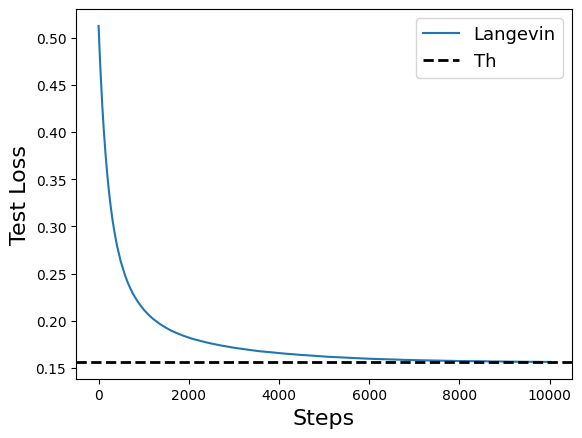

In [16]:
plt.plot(test_losses, label = 'Langevin')
plt.axhline(y=err, linestyle ='--', color='black', linewidth = 2, label=r'Th')
plt.legend(fontsize = 13)
plt.xlabel('Steps', fontsize = 16)
plt.ylabel('Test Loss', fontsize = 16)

np.mean(test_losses[6000:])

In [3]:
# standard NTK parameterization
# deep Langevin dynamics 
import optax

def nonlinear_fn(params, X):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)  
    h = h * (h > 0.0)
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        h = h * (h > 0.0)

    N = params[-1].shape[0]
    f = h.T @ params[-1] / jnp.sqrt(N)
    return f

def nonlinear_fn_reps(params, X):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    h = h * (h > 0.0)
    all_h = [ h.T @ h / h.shape[0] ]
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        h = h * (h > 0.0)
        all_h += [ h.T @ h / h.shape[0] ]
    N = params[-1].shape[0]
    f = h.T @ params[-1] / jnp.sqrt(N)
    return f, all_h

def deep_nonlinear_ntk(X, y, P, N, L, T, eta, beta, seed = 2, center = False, sigma=0.0):
    key = random.PRNGKey(seed)

    M = X.shape[0]

    Ws = [random.normal(random.PRNGKey(seed), (N, M) )]

    for i in range(L-1):
        Ws += [ random.normal(random.PRNGKey(seed+i), ( N ,  N ) ) ]

    Ws += [ random.normal(random.PRNGKey(seed+L), (N,) ) ]

    reg_loss_fn = jit(lambda p: 0.5 * jnp.sum( ( nonlinear_fn(p, X[:,:P])  - y[:P] )**2 ) +  0.5/beta * optimizers.l2_norm(p)**2 )

    test_loss_fn = jit(lambda p: jnp.mean( ( nonlinear_fn(p, X[:,P:])  - y[P:] )**2 ))

    solver = optax.noisy_sgd(learning_rate = eta , eta = 2.0*eta/beta, gamma= 0.0)

    grad_fn = jit( grad(reg_loss_fn) )
    opt_state = solver.init( Ws )
    train_losses = []
    test_losses = []

    params = Ws.copy()

    H_avgs = []
    all_cs = []
    count = 0

    for t in range(T):

        train_losses += [ reg_loss_fn(params) ]
        test_losses += [test_loss_fn(params)]
        


        if t> 10000 and t % 10:
          _, Hs = nonlinear_fn_reps(params, X[:,:P])
          all_cs += [ [jnp.dot(y[:P], H @ y[:P]) for H in Hs] ]
          if count == 0:
            H_avgs = [ H for H in Hs ]
          else:
            H_avgs = [  count / (count+1) * H_avgs[i] + 1/(count+1) * H for i, H in enumerate(Hs) ]

          count += 1
        grads = grad_fn(params)
        key, subkey = random.split(key)
        updates, opt_state = solver.update(grads, opt_state, params, rng=subkey)
        params = optax.apply_updates(params, updates)
    

    return train_losses, test_losses, H_avgs, all_cs, params, Ws

In [11]:
L = 1
beta = 1000 # to approximate beta Inf
seed = 45


N = 10000
eta = 5e-3
T = 2000

train_losses, test_losses, H_avg, all_cs, params1, Ws = deep_nonlinear_ntk(X, y, P, N, L, T, eta, beta, seed=seed)

0.18362238

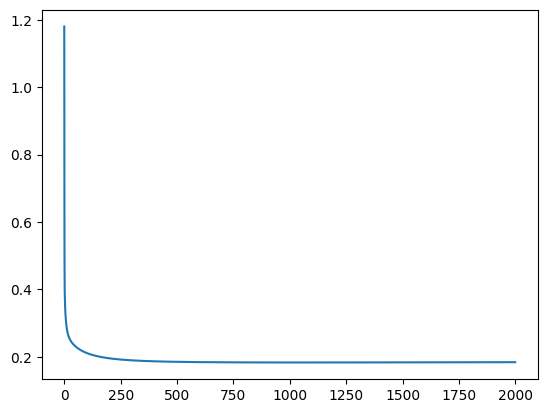

In [12]:
plt.plot(test_losses)
np.mean(test_losses[1000:])

In [13]:
# Lazy NNGP kernel and predictor
# beta is Inf in the NNGP theory

def relu_kernel_closed_form(C):
    var   = jnp.diag(C)
    outer = jnp.sqrt(var)[:,None]*jnp.sqrt(var)[None,:]
    U     = jnp.clip(C/outer,-1,1)
    θ     = jnp.arccos(U)
    κ     = (jnp.sin(θ)+(jnp.pi-θ)*U)/(2*jnp.pi)
    return outer * κ

def nngp(Ctot, y_train, y_test, beta):
    K = relu_kernel_closed_form(Ctot)
    P = y_train.shape[0]
    K_train = K[:P,:P]
    K_inv = jnp.linalg.inv(K_train )
    K_traintest = K[P:,:P]
    K_testtest  = K[P:, P:] 
    preds = K_traintest @ K_inv @ y_train
    
    bias2 = (y_test - preds)**2
    tmp      = K_traintest @ K_inv
    variance = jnp.diag(K_testtest) - jnp.sum(tmp * K_traintest, axis=1)
    
    return jnp.mean(bias2), jnp.mean(bias2) + jnp.mean(variance) 

In [14]:
K = relu_kernel_closed_form(Ctot)

In [15]:
beta = 100
bias, err = nngp(Ctot, y_train, y_test, beta)

In [16]:
bias

Array(0.17398313, dtype=float32)